In [ ]:
!pip install requests pandas statsmodels

import requests
import pandas as pd
import numpy as np
import statsmodels.api as sm


In [ ]:
# ===================== 0. Imports =====================
!pip install yfinance -q

import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from io import BytesIO
import zipfile
import requests
from datetime import datetime, timedelta

# ===================== 1. Date range (past 1 year, daily) =====================
end = datetime.today()
start = end - timedelta(days=365)

# ===================== 2. COIN daily prices & returns (yfinance) =====================
coin_raw = yf.download(
    "COIN",
    start=start,
    end=end,
    auto_adjust=True,
    progress=False
)

# Keep just the close and make a proper date column
coin = coin_raw[["Close"]].copy()
coin = coin.reset_index()                    # 'Date' -> normal column
coin = coin.rename(columns={"Date": "date", "Close": "close"})

# Compute log returns
coin["coin_ret"] = np.log(coin["close"] / coin["close"].shift(1))
coin = coin[["date", "coin_ret"]].dropna()

# Ensure flat columns and correct dtypes
coin.columns = ["date", "coin_ret"]
coin["date"] = pd.to_datetime(coin["date"])
coin = coin.reset_index(drop=True)

print("COIN head:")
print(coin.head())
print("COIN dtypes:")
print(coin.dtypes)
print()

# ===================== 3. Fama–French daily factors (Ken French library) =====================
ff_url = (
    "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/"
    "F-F_Research_Data_Factors_daily_CSV.zip"
)

resp = requests.get(ff_url)
resp.raise_for_status()

with zipfile.ZipFile(BytesIO(resp.content)) as z:
    fname = [n for n in z.namelist() if n.endswith(".csv")][0]
    # Ken French CSVs have a text header; skip the first 4 rows
    ff = pd.read_csv(z.open(fname), skiprows=4)

# Clean Ken French data
ff = ff.rename(columns={ff.columns[0]: "date"})

# Drop footer rows (non-numeric dates)
ff["date_num"] = pd.to_numeric(ff["date"], errors="coerce")
ff = ff.dropna(subset=["date_num"])

# Convert YYYYMMDD -> datetime
ff["date"] = pd.to_datetime(ff["date_num"].astype(int).astype(str), format="%Y%m%d")

# Keep only needed columns and convert percent -> decimal
ff = ff[["date", "Mkt-RF", "SMB", "HML", "RF"]].copy()
ff[["Mkt-RF", "SMB", "HML", "RF"]] = ff[["Mkt-RF", "SMB", "HML", "RF"]].astype(float) / 100.0

# Restrict to same date range
ff = ff[(ff["date"] >= start) & (ff["date"] <= end)].reset_index(drop=True)

print("FF head:")
print(ff.head())
print("FF dtypes:")
print(ff.dtypes)
print()

# ===================== 4. Merge on 'date' (simple columns, simple index) =====================
data = pd.merge(coin, ff, on="date", how="inner").dropna()
data = data.sort_values("date").set_index("date")

print("Merged data head:")
print(data.head())
print()

# ===================== 5. Define OLS regression =====================
# Dependent variable: COIN excess return over risk-free rate
y = data["coin_ret"] - data["RF"]

# Explanatory variables: Fama–French factors
X = data[["Mkt-RF", "SMB", "HML"]]
X = sm.add_constant(X)  # add intercept

# ===================== 6. Run OLS regression =====================
ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())


COIN head:
        date  coin_ret
0 2024-12-09 -0.101288
1 2024-12-10 -0.026431
2 2024-12-11  0.036971
3 2024-12-12 -0.002712
4 2024-12-13 -0.007634
COIN dtypes:
date        datetime64[ns]
coin_ret           float64
dtype: object

FF head:
        date  Mkt-RF     SMB     HML      RF
0 2024-12-09 -0.0073  0.0041  0.0013  0.0002
1 2024-12-10 -0.0036 -0.0003  0.0014  0.0002
2 2024-12-11  0.0087  0.0017 -0.0058  0.0002
3 2024-12-12 -0.0062 -0.0086  0.0041  0.0002
4 2024-12-13 -0.0005 -0.0048 -0.0030  0.0002
FF dtypes:
date      datetime64[ns]
Mkt-RF           float64
SMB              float64
HML              float64
RF               float64
dtype: object

Merged data head:
            coin_ret  Mkt-RF     SMB     HML      RF
date                                                
2024-12-09 -0.101288 -0.0073  0.0041  0.0013  0.0002
2024-12-10 -0.026431 -0.0036 -0.0003  0.0014  0.0002
2024-12-11  0.036971  0.0087  0.0017 -0.0058  0.0002
2024-12-12 -0.002712 -0.0062 -0.0086  0.0041  0.0002
202

In [ ]:
MASSIVE_API_KEY = "ldSSvWepgccVRtv9PQn3xXpLkQb9D77I"


In [ ]:
!pip install boto3 pandas -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 2.9 MB/s eta 0:00:00


In [ ]:
# ===================== MASSIVE MINUTE AGGS → COIN =====================

# 1. Install + imports
!pip install boto3 pandas -q

import boto3
from botocore.config import Config
import pandas as pd
from datetime import datetime, timedelta
from io import BytesIO
import gzip

# 2. Create S3 client (Massive Flat Files)
s3 = boto3.client(
    "s3",
    endpoint_url="https://files.massive.com",
    aws_access_key_id="c50ee579-c7f9-4057-ae75-06d317bf0e3c",
    aws_secret_access_key="ldSSvWepgccVRtv9PQn3xXpLkQb9D77I",
    config=Config(signature_version="s3v4"),
)

# 3. Date range (past 1 year)
END_DATE = datetime.utcnow().date()
START_DATE = END_DATE - timedelta(days=365)

def daterange(start, end):
    d = start
    while d <= end:
        yield d
        d += timedelta(days=1)

# 4. Download COIN minute aggregates (CORRECT PATH)
BUCKET = "flatfiles"
BASE_PREFIX = "us_stocks_sip/minute_aggs_v1"
dfs = []

for day in daterange(START_DATE, END_DATE):
    year = day.strftime("%Y")
    month = day.strftime("%m")   # ✅ numeric month folders (09, 10, 11, 12)
    fname = f"{day.strftime('%Y-%m-%d')}.csv.gz"
    key = f"{BASE_PREFIX}/{year}/{month}/{fname}"

    try:
        obj = s3.get_object(Bucket=BUCKET, Key=key)

        with gzip.GzipFile(fileobj=BytesIO(obj["Body"].read())) as gz:
            df = pd.read_csv(gz)

        # Filter COIN only
        df = df[df["ticker"] == "COIN"]

        if not df.empty:
            df["window_start"] = pd.to_datetime(df["window_start"], utc=True)
            dfs.append(df)

        print(f"✅ {fname} → {len(df)} rows")

    except Exception as e:
        print(f"⚠️ {fname} → {e}")

# 5. Combine minute data
coin_1min = (
    pd.concat(dfs)
    .sort_values("window_start")
    .reset_index(drop=True)
)

print("\nMinute rows:", len(coin_1min))
print("Range:", coin_1min["window_start"].min(), "→", coin_1min["window_start"].max())

# 6. Resample → hourly
coin_hourly = (
    coin_1min
    .set_index("window_start")
    .resample("1H")
    .agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum",
        "transactions": "sum",
    })
    .dropna()
    .reset_index()
)

print("\nHourly rows:", len(coin_hourly))

# 7. Save
coin_hourly.to_csv("COIN_hourly_1y_massive.csv", index=False)
coin_hourly.to_parquet("COIN_hourly_1y_massive.parquet", index=False)

print("\n✅ DONE — COIN hourly data saved")


/tmp/ipython-input-1831817888.py:23: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  END_DATE = datetime.utcnow().date()


⚠️ 2024-12-08.csv.gz → An error occurred (NoSuchKey) when calling the GetObject operation: Unknown
✅ 2024-12-09.csv.gz → 830 rows
✅ 2024-12-10.csv.gz → 729 rows
✅ 2024-12-11.csv.gz → 723 rows
✅ 2024-12-12.csv.gz → 660 rows
✅ 2024-12-13.csv.gz → 595 rows
⚠️ 2024-12-14.csv.gz → An error occurred (NoSuchKey) when calling the GetObject operation: Unknown
⚠️ 2024-12-15.csv.gz → An error occurred (NoSuchKey) when calling the GetObject operation: Unknown
✅ 2024-12-16.csv.gz → 706 rows
✅ 2024-12-17.csv.gz → 640 rows
✅ 2024-12-18.csv.gz → 728 rows
✅ 2024-12-19.csv.gz → 689 rows
✅ 2024-12-20.csv.gz → 800 rows
⚠️ 2024-12-21.csv.gz → An error occurred (NoSuchKey) when calling the GetObject operation: Unknown
⚠️ 2024-12-22.csv.gz → An error occurred (NoSuchKey) when calling the GetObject operation: Unknown
✅ 2024-12-23.csv.gz → 668 rows
✅ 2024-12-24.csv.gz → 363 rows
⚠️ 2024-12-25.csv.gz → An error occurred (NoSuchKey) when calling the GetObject operation: Unknown
✅ 2024-12-26.csv.gz → 606 rows
✅ 2

/tmp/ipython-input-1831817888.py:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H")



✅ DONE — COIN hourly data saved


In [ ]:
# ===================== MASSIVE MINUTE AGGS → SPY (S&P PROXY) =====================

# 1. Install + imports
!pip install boto3 pandas -q

import boto3
from botocore.config import Config
import pandas as pd
from datetime import datetime, timedelta, timezone
from io import BytesIO
import gzip

# 2. Create S3 client (Massive Flat Files)
s3 = boto3.client(
    "s3",
    endpoint_url="https://files.massive.com",
    aws_access_key_id="c50ee579-c7f9-4057-ae75-06d317bf0e3c",
    aws_secret_access_key="ldSSvWepgccVRtv9PQn3xXpLkQb9D77I",
    config=Config(signature_version="s3v4"),
)

# 3. Date range (past 1 year)
# (use timezone-aware now to avoid the deprecation warning)
END_DATE = datetime.now(timezone.utc).date()
START_DATE = END_DATE - timedelta(days=365)

def daterange(start, end):
    d = start
    while d <= end:
        yield d
        d += timedelta(days=1)

# 4. Download SPY minute aggregates (same path, different ticker)
BUCKET = "flatfiles"
BASE_PREFIX = "us_stocks_sip/minute_aggs_v1"
TICKER = "SPY"

dfs = []

for day in daterange(START_DATE, END_DATE):
    year = day.strftime("%Y")
    month = day.strftime("%m")   # numeric month folders (09, 10, 11, 12)
    fname = f"{day.strftime('%Y-%m-%d')}.csv.gz"
    key = f"{BASE_PREFIX}/{year}/{month}/{fname}"

    try:
        obj = s3.get_object(Bucket=BUCKET, Key=key)

        with gzip.GzipFile(fileobj=BytesIO(obj["Body"].read())) as gz:
            df = pd.read_csv(gz)

        # Filter SPY only
        df = df[df["ticker"] == TICKER]

        if not df.empty:
            df["window_start"] = pd.to_datetime(df["window_start"], utc=True)
            dfs.append(df)

        print(f"✅ {fname} → {len(df)} rows ({TICKER})")

    except Exception as e:
        print(f"⚠️ {fname} → {e}")

# 5. Combine minute data
spy_1min = (
    pd.concat(dfs)
    .sort_values("window_start")
    .reset_index(drop=True)
)

print("\nMinute rows:", len(spy_1min))
print("Range:", spy_1min["window_start"].min(), "→", spy_1min["window_start"].max())

# 6. Resample → hourly
spy_hourly = (
    spy_1min
    .set_index("window_start")
    .resample("1H")
    .agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum",
        "transactions": "sum",
    })
    .dropna()
    .reset_index()
)

print("\nHourly rows:", len(spy_hourly))

# 7. Save
spy_hourly.to_csv("SPY_hourly_1y_massive.csv", index=False)
spy_hourly.to_parquet("SPY_hourly_1y_massive.parquet", index=False)

print("\n✅ DONE — SPY hourly data saved")


✅ 2024-12-09.csv.gz → 759 rows (SPY)
✅ 2024-12-10.csv.gz → 707 rows (SPY)
✅ 2024-12-11.csv.gz → 738 rows (SPY)
✅ 2024-12-12.csv.gz → 769 rows (SPY)
✅ 2024-12-13.csv.gz → 739 rows (SPY)
⚠️ 2024-12-14.csv.gz → An error occurred (NoSuchKey) when calling the GetObject operation: Unknown
⚠️ 2024-12-15.csv.gz → An error occurred (NoSuchKey) when calling the GetObject operation: Unknown
✅ 2024-12-16.csv.gz → 736 rows (SPY)
✅ 2024-12-17.csv.gz → 762 rows (SPY)
✅ 2024-12-18.csv.gz → 815 rows (SPY)
✅ 2024-12-19.csv.gz → 878 rows (SPY)
✅ 2024-12-20.csv.gz → 909 rows (SPY)
⚠️ 2024-12-21.csv.gz → An error occurred (NoSuchKey) when calling the GetObject operation: Unknown
⚠️ 2024-12-22.csv.gz → An error occurred (NoSuchKey) when calling the GetObject operation: Unknown
✅ 2024-12-23.csv.gz → 803 rows (SPY)
✅ 2024-12-24.csv.gz → 416 rows (SPY)
⚠️ 2024-12-25.csv.gz → An error occurred (NoSuchKey) when calling the GetObject operation: Unknown
✅ 2024-12-26.csv.gz → 758 rows (SPY)
✅ 2024-12-27.csv.gz → 71

/tmp/ipython-input-3180572139.py:78: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H")


In [ ]:
from google.colab import files

files.download("SPY_hourly_1y_massive.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ===================== MASSIVE MINUTE AGGS → IWV (Russell 3000) =====================

import pandas as pd
from io import BytesIO
import gzip

# Assumes s3, START_DATE, END_DATE, daterange() already exist
# (same setup as your COIN / SPY cells)

BUCKET = "flatfiles"
BASE_PREFIX = "us_stocks_sip/minute_aggs_v1"
TICKER = "IWV"  # Russell 3000 ETF

dfs = []

for day in daterange(START_DATE, END_DATE):
    year = day.strftime("%Y")
    month = day.strftime("%m")
    fname = f"{day.strftime('%Y-%m-%d')}.csv.gz"
    key = f"{BASE_PREFIX}/{year}/{month}/{fname}"

    try:
        obj = s3.get_object(Bucket=BUCKET, Key=key)

        with gzip.GzipFile(fileobj=BytesIO(obj["Body"].read())) as gz:
            df = pd.read_csv(gz)

        df = df[df["ticker"] == TICKER]

        if not df.empty:
            df["window_start"] = pd.to_datetime(df["window_start"], utc=True)
            dfs.append(df)

        print(f"✅ {fname} → {len(df)} rows ({TICKER})")

    except Exception as e:
        print(f"⚠️ {fname} → {e}")

# ---- Combine minutes ----
if not dfs:
    raise ValueError("No IWV data found — likely permissions issue.")

iwv_1min = (
    pd.concat(dfs)
    .sort_values("window_start")
    .reset_index(drop=True)
)

print("\nMinute rows:", len(iwv_1min))
print("Range:", iwv_1min["window_start"].min(), "→", iwv_1min["window_start"].max())

# ---- Resample to hourly ----
iwv_hourly = (
    iwv_1min
    .set_index("window_start")
    .resample("1h")
    .agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum",
        "transactions": "sum",
    })
    .dropna()
    .reset_index()
)

print("\nHourly rows:", len(iwv_hourly))

# ---- Save ----
iwv_hourly.to_csv("IWV_hourly_1y_massive.csv", index=False)
iwv_hourly.to_parquet("IWV_hourly_1y_massive.parquet", index=False)

print("\n✅ DONE — IWV (Russell 3000) hourly data saved")


✅ 2024-12-09.csv.gz → 133 rows (IWV)
✅ 2024-12-10.csv.gz → 152 rows (IWV)
✅ 2024-12-11.csv.gz → 147 rows (IWV)
✅ 2024-12-12.csv.gz → 172 rows (IWV)
✅ 2024-12-13.csv.gz → 135 rows (IWV)
⚠️ 2024-12-14.csv.gz → An error occurred (NoSuchKey) when calling the GetObject operation: None
⚠️ 2024-12-15.csv.gz → An error occurred (NoSuchKey) when calling the GetObject operation: None
✅ 2024-12-16.csv.gz → 249 rows (IWV)
✅ 2024-12-17.csv.gz → 197 rows (IWV)
✅ 2024-12-18.csv.gz → 193 rows (IWV)
✅ 2024-12-19.csv.gz → 223 rows (IWV)
✅ 2024-12-20.csv.gz → 249 rows (IWV)
⚠️ 2024-12-21.csv.gz → An error occurred (NoSuchKey) when calling the GetObject operation: None
⚠️ 2024-12-22.csv.gz → An error occurred (NoSuchKey) when calling the GetObject operation: None
✅ 2024-12-23.csv.gz → 220 rows (IWV)
✅ 2024-12-24.csv.gz → 120 rows (IWV)
⚠️ 2024-12-25.csv.gz → An error occurred (NoSuchKey) when calling the GetObject operation: None
✅ 2024-12-26.csv.gz → 162 rows (IWV)
✅ 2024-12-27.csv.gz → 163 rows (IWV)
⚠️

In [ ]:
from google.colab import files
files.download("IWV_hourly_1y_massive.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ===================== MASSIVE MINUTE AGGS → QQQ =====================

import pandas as pd
from io import BytesIO
import gzip

# Assumes the following ALREADY exist from earlier cells:
# - s3 client
# - START_DATE, END_DATE
# - daterange(start, end)

BUCKET = "flatfiles"
BASE_PREFIX = "us_stocks_sip/minute_aggs_v1"
TICKER = "QQQ"

dfs = []

for day in daterange(START_DATE, END_DATE):
    year = day.strftime("%Y")
    month = day.strftime("%m")
    fname = f"{day.strftime('%Y-%m-%d')}.csv.gz"
    key = f"{BASE_PREFIX}/{year}/{month}/{fname}"

    try:
        obj = s3.get_object(Bucket=BUCKET, Key=key)

        with gzip.GzipFile(fileobj=BytesIO(obj["Body"].read())) as gz:
            df = pd.read_csv(gz)

        df = df[df["ticker"] == TICKER]

        if not df.empty:
            df["window_start"] = pd.to_datetime(df["window_start"], utc=True)
            dfs.append(df)

        print(f"✅ {fname} → {len(df)} rows (QQQ)")

    except Exception as e:
        print(f"⚠️ {fname} → {e}")

# ---- Combine minutes ----
if not dfs:
    raise ValueError("No QQQ data found — permissions or date issue.")

qqq_1min = (
    pd.concat(dfs)
    .sort_values("window_start")
    .reset_index(drop=True)
)

print("\nMinute rows:", len(qqq_1min))
print("Range:", qqq_1min["window_start"].min(), "→", qqq_1min["window_start"].max())

# ---- Resample to hourly ----
qqq_hourly = (
    qqq_1min
    .set_index("window_start")
    .resample("1h")
    .agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum",
        "transactions": "sum",
    })
    .dropna()
    .reset_index()
)

print("\nHourly rows:", len(qqq_hourly))

# ---- Save ----
qqq_hourly.to_csv("QQQ_hourly_1y_massive.csv", index=False)
qqq_hourly.to_parquet("QQQ_hourly_1y_massive.parquet", index=False)

print("\n✅ DONE — QQQ hourly data saved from Massive API")


✅ 2024-12-09.csv.gz → 855 rows (QQQ)
✅ 2024-12-10.csv.gz → 794 rows (QQQ)
✅ 2024-12-11.csv.gz → 814 rows (QQQ)
✅ 2024-12-12.csv.gz → 882 rows (QQQ)
✅ 2024-12-13.csv.gz → 788 rows (QQQ)
⚠️ 2024-12-14.csv.gz → An error occurred (NoSuchKey) when calling the GetObject operation: None
⚠️ 2024-12-15.csv.gz → An error occurred (NoSuchKey) when calling the GetObject operation: None
✅ 2024-12-16.csv.gz → 852 rows (QQQ)
✅ 2024-12-17.csv.gz → 871 rows (QQQ)
✅ 2024-12-18.csv.gz → 895 rows (QQQ)
✅ 2024-12-19.csv.gz → 912 rows (QQQ)
✅ 2024-12-20.csv.gz → 910 rows (QQQ)
⚠️ 2024-12-21.csv.gz → An error occurred (NoSuchKey) when calling the GetObject operation: None
⚠️ 2024-12-22.csv.gz → An error occurred (NoSuchKey) when calling the GetObject operation: None
✅ 2024-12-23.csv.gz → 857 rows (QQQ)
✅ 2024-12-24.csv.gz → 470 rows (QQQ)
⚠️ 2024-12-25.csv.gz → An error occurred (NoSuchKey) when calling the GetObject operation: None
✅ 2024-12-26.csv.gz → 805 rows (QQQ)
✅ 2024-12-27.csv.gz → 749 rows (QQQ)
⚠️

In [ ]:
from google.colab import files
files.download("QQQ_hourly_1y_massive.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ===================== MASSIVE MINUTE AGGS → QQQ (past 1 year) =====================

!pip install boto3 pandas -q

import boto3
from botocore.config import Config
import pandas as pd
from datetime import datetime, timedelta, timezone
from io import BytesIO
import gzip

# ---- S3 client (Massive) ----
s3 = boto3.client(
    "s3",
    endpoint_url="https://files.massive.com",
    aws_access_key_id="YOUR_ACCESS_KEY",
    aws_secret_access_key="YOUR_SECRET_KEY",
    config=Config(signature_version="s3v4"),
)

# ---- Date range: past 1 year ----
END_DATE = datetime.now(timezone.utc).date()
START_DATE = END_DATE - timedelta(days=365)

def daterange(start, end):
    d = start
    while d <= end:
        yield d
        d += timedelta(days=1)

# ---- Download QQQ minute aggregates ----
BUCKET = "flatfiles"
BASE_PREFIX = "us_stocks_sip/minute_aggs_v1"
TICKER = "QQQ"

dfs = []

for day in daterange(START_DATE, END_DATE):
    year = day.strftime("%Y")
    month = day.strftime("%m")
    fname = f"{day.strftime('%Y-%m-%d')}.csv.gz"
    key = f"{BASE_PREFIX}/{year}/{month}/{fname}"

    try:
        obj = s3.get_object(Bucket=BUCKET, Key=key)
        with gzip.GzipFile(fileobj=BytesIO(obj["Body"].read())) as gz:
            df = pd.read_csv(gz)

        df = df[df["ticker"] == TICKER]

        if not df.empty:
            df["window_start"] = pd.to_datetime(df["window_start"], utc=True)
            dfs.append(df)

        print(f"✅ {fname} → {len(df)} rows (QQQ)")
    except Exception as e:
        print(f"⚠️ {fname} → {e}")

# ---- Combine minutes ----
qqq_1min = (
    pd.concat(dfs)
    .sort_values("window_start")
    .reset_index(drop=True)
)

print("\nMinute rows:", len(qqq_1min))
print("Range:", qqq_1min["window_start"].min(), "→", qqq_1min["window_start"].max())

# ---- Resample to hourly ----
qqq_hourly = (
    qqq_1min
    .set_index("window_start")
    .resample("1h")
    .agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum",
        "transactions": "sum",
    })
    .dropna()
    .reset_index()
)

print("\nHourly rows:", len(qqq_hourly))

# ---- Save ----
qqq_hourly.to_csv("QQQ_hourly_1y_massive.csv", index=False)
qqq_hourly.to_parquet("QQQ_hourly_1y_massive.parquet", index=False)

print("\n✅ DONE — QQQ hourly data saved")


⚠️ 2024-12-09.csv.gz → An error occurred (403) when calling the GetObject operation: Forbidden
⚠️ 2024-12-10.csv.gz → An error occurred (403) when calling the GetObject operation: Forbidden
⚠️ 2024-12-11.csv.gz → An error occurred (403) when calling the GetObject operation: Forbidden
⚠️ 2024-12-12.csv.gz → An error occurred (403) when calling the GetObject operation: Forbidden
⚠️ 2024-12-13.csv.gz → An error occurred (403) when calling the GetObject operation: Forbidden
⚠️ 2024-12-14.csv.gz → An error occurred (403) when calling the GetObject operation: Forbidden
⚠️ 2024-12-15.csv.gz → An error occurred (403) when calling the GetObject operation: Forbidden
⚠️ 2024-12-16.csv.gz → An error occurred (403) when calling the GetObject operation: Forbidden
⚠️ 2024-12-17.csv.gz → An error occurred (403) when calling the GetObject operation: Forbidden
⚠️ 2024-12-18.csv.gz → An error occurred (403) when calling the GetObject operation: Forbidden
⚠️ 2024-12-19.csv.gz → An error occurred (403) whe

ValueError: No objects to concatenate

In [ ]:
from google.colab import files

files.download("COIN_hourly_1y_massive.csv")
# or
files.download("COIN_hourly_1y_massive.parquet")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ===================== BTCUSD 1-min from Bitstamp (past 1 year) =====================
import time
from datetime import datetime, timedelta, timezone

import pandas as pd
import requests

# ---------- 1. Helper: fetch one chunk from Bitstamp ----------
def fetch_bitstamp_ohlc(currency_pair, start_ts, end_ts, step=60, limit=1000):
    """
    Fetch OHLC data from Bitstamp API for a given time window.

    Args:
        currency_pair: e.g. "btcusd"
        start_ts: Unix timestamp (seconds)
        end_ts: Unix timestamp (seconds)
        step: bar length in seconds (60 = 1 minute)
        limit: max number of rows Bitstamp will return

    Returns:
        List of dicts with keys: timestamp, open, high, low, close, volume
    """
    url = f"https://www.bitstamp.net/api/v2/ohlc/{currency_pair}/"
    params = {
        "step": step,
        "start": int(start_ts),
        "end": int(end_ts),
        "limit": limit,
    }
    r = requests.get(url, params=params, timeout=60)
    r.raise_for_status()
    return r.json().get("data", {}).get("ohlc", [])


# ---------- 2. Fixed date range: past 1 year (no autodetect from files) ----------
PAIR = "btcusd"
STEP = 60          # 1-minute bars
LIMIT = 1000       # Bitstamp max rows per request

# End time: now (UTC) minus 10 minutes to avoid partial newest data
end_dt = datetime.now(timezone.utc) - timedelta(minutes=10)
start_dt = end_dt - timedelta(days=365)

end_ts = int(end_dt.timestamp())
start_ts = int(start_dt.timestamp())

print(f"Target range: {start_dt}  →  {end_dt}")

# Each API call covers at most LIMIT * STEP seconds
chunk_span = LIMIT * STEP  # seconds per chunk

# ---------- 3. Loop over chunks and collect data ----------
all_rows = []
current_start = start_ts
chunk_num = 0

while current_start < end_ts:
    current_end = min(current_start + chunk_span, end_ts)
    chunk_num += 1
    print(
        f"Chunk {chunk_num}: "
        f"{datetime.fromtimestamp(current_start, tz=timezone.utc)} → "
        f"{datetime.fromtimestamp(current_end, tz=timezone.utc)}"
    )

    try:
        ohlc = fetch_bitstamp_ohlc(PAIR, current_start, current_end, step=STEP, limit=LIMIT)
    except Exception as e:
        print("  ERROR:", e)
        ohlc = []

    if ohlc:
        all_rows.extend(ohlc)
        print(f"  Retrieved {len(ohlc)} rows")
    else:
        print("  No data returned for this chunk")

    current_start = current_end
    time.sleep(1)  # be nice to the API

print(f"\nTotal raw rows fetched: {len(all_rows)}")

# ---------- 4. Build DataFrame and clean ----------
df_btc = pd.DataFrame(all_rows)

# Ensure numeric types
df_btc["timestamp"] = pd.to_numeric(df_btc["timestamp"], errors="coerce")
df_btc = df_btc.dropna(subset=["timestamp"])

for col in ["open", "high", "low", "close", "volume"]:
    df_btc[col] = pd.to_numeric(df_btc[col], errors="coerce")

# Add a proper datetime column in UTC
df_btc["datetime"] = pd.to_datetime(df_btc["timestamp"], unit="s", utc=True)

# Sort and reset index
df_btc = df_btc.sort_values("datetime").reset_index(drop=True)

print("\nCleaned BTC data:")
print(df_btc.head())
print("Rows:", len(df_btc))
print("Range:", df_btc["datetime"].min(), "→", df_btc["datetime"].max())

# ---------- 5. Save to CSV ----------
out_name = "BTCUSD_1min_1y_bitstamp.csv"
df_btc.to_csv(out_name, index=False)
print(f"\n✅ Saved to {out_name}")


Target range: 2024-12-08 23:13:52.500799+00:00  →  2025-12-08 23:13:52.500799+00:00
Chunk 1: 2024-12-08 23:13:52+00:00 → 2024-12-09 15:53:52+00:00
  Retrieved 1000 rows
Chunk 2: 2024-12-09 15:53:52+00:00 → 2024-12-10 08:33:52+00:00
  Retrieved 1000 rows
Chunk 3: 2024-12-10 08:33:52+00:00 → 2024-12-11 01:13:52+00:00
  Retrieved 1000 rows
Chunk 4: 2024-12-11 01:13:52+00:00 → 2024-12-11 17:53:52+00:00
  Retrieved 1000 rows
Chunk 5: 2024-12-11 17:53:52+00:00 → 2024-12-12 10:33:52+00:00
  Retrieved 1000 rows
Chunk 6: 2024-12-12 10:33:52+00:00 → 2024-12-13 03:13:52+00:00
  Retrieved 1000 rows
Chunk 7: 2024-12-13 03:13:52+00:00 → 2024-12-13 19:53:52+00:00
  Retrieved 1000 rows
Chunk 8: 2024-12-13 19:53:52+00:00 → 2024-12-14 12:33:52+00:00
  Retrieved 1000 rows
Chunk 9: 2024-12-14 12:33:52+00:00 → 2024-12-15 05:13:52+00:00
  Retrieved 1000 rows
Chunk 10: 2024-12-15 05:13:52+00:00 → 2024-12-15 21:53:52+00:00
  Retrieved 1000 rows
Chunk 11: 2024-12-15 21:53:52+00:00 → 2024-12-16 14:33:52+00:00
 

In [ ]:
from google.colab import files

files.download("BTCUSD_1min_1y_bitstamp.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

files.download("BTCUSD_1min_1y_bitstamp.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
# ===================== ALL-IN-ONE CELL: BTC + {SPY, QQQ, IWV} MODELS =====================

# 1. Installs & Imports
!pip install -q scikit-learn

import pandas as pd
import numpy as np
from datetime import datetime
from google.colab import drive

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# 2. Mount Google Drive
drive.mount("/content/drive")


# 3. ---- FILE PATHS (MATCH YOUR DRIVE NAMES) ----
# Make sure these filenames exist in /content/drive/MyDrive

BTC_PATH = "/content/drive/MyDrive/BTCUSD_1min_1y_bitstamp.csv"
SPY_PATH = "/content/drive/MyDrive/SPY_hourly_1y_massive.csv"
QQQ_PATH = "/content/drive/MyDrive/QQQ_hourly_1y_massive.csv"
IWV_PATH = "/content/drive/MyDrive/IWV_hourly_1y_massive.csv"  # Note: IWV (not IWF)


# 4. ---- LOAD BTC (1-min) AND RESAMPLE TO HOURLY ----

btc_1min = pd.read_csv(BTC_PATH)

# Expect columns like: ['timestamp','open','high','low','close','volume', ..., 'datetime']
# If 'datetime' not present, build from 'timestamp'
if "datetime" in btc_1min.columns:
    btc_1min["datetime"] = pd.to_datetime(btc_1min["datetime"], utc=True)
else:
    btc_1min["datetime"] = pd.to_datetime(btc_1min["timestamp"], unit="s", utc=True)

btc_hourly = (
    btc_1min
    .set_index("datetime")
    .resample("1H")
    .agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum"
    })
    .dropna()
    .reset_index()
)

btc_hourly = btc_hourly.rename(columns={"close": "btc_close"})
btc_hourly = btc_hourly.sort_values("datetime").reset_index(drop=True)

print("BTC hourly shape:", btc_hourly.shape)
print("BTC hourly range:", btc_hourly["datetime"].min(), "→", btc_hourly["datetime"].max())


# 5. ---- HELPER: LOAD ETF HOURLY CSV ----

def load_etf_hourly(path, etf_name):
    """
    Expect 'massive' format with columns:
    window_start, open, high, low, close, volume, transactions, ticker
    """
    df = pd.read_csv(path)

    # Ensure datetime is proper UTC
    df["window_start"] = pd.to_datetime(df["window_start"], utc=True, errors="coerce")
    df = df.dropna(subset=["window_start"])

    # If multiple tickers somehow, filter just in case
    if "ticker" in df.columns:
        df = df[df["ticker"] == etf_name]

    df = df.sort_values("window_start").reset_index(drop=True)
    df = df.rename(columns={"close": f"{etf_name.lower()}_close"})

    print(f"{etf_name} hourly shape:", df.shape)
    print(f"{etf_name} hourly range:", df['window_start'].min(), "→", df['window_start'].max())
    return df


spy_hourly = load_etf_hourly(SPY_PATH, "SPY")
qqq_hourly = load_etf_hourly(QQQ_PATH, "QQQ")
iwv_hourly = load_etf_hourly(IWV_PATH, "IWV")


# 6. ---- HELPER: BUILD FEATURES + MODEL FOR BTC + ONE ETF ----

def build_pair_model(btc_df, etf_df, etf_name, test_size=0.25):
    """
    btc_df: hourly BTC dataframe with 'datetime' + 'btc_close'
    etf_df: hourly ETF dataframe with 'window_start' + '{etf}_close'
    etf_name: 'SPY', 'QQQ', 'IWV'
    """
    etf_col = f"{etf_name.lower()}_close"

    # Align on hourly timestamps (inner join)
    merged = pd.merge(
        etf_df[["window_start", etf_col]],
        btc_df[["datetime", "btc_close"]],
        left_on="window_start",
        right_on="datetime",
        how="inner"
    )

    # Use a unified timestamp column
    merged = merged.rename(columns={"window_start": "timestamp"})
    merged = merged.drop(columns=["datetime"])
    merged = merged.sort_values("timestamp").reset_index(drop=True)

    print(f"\n===== {etf_name}: after align with BTC =====")
    print("Rows:", len(merged))
    print("Range:", merged["timestamp"].min(), "→", merged["timestamp"].max())

    # Compute 1-hour returns
    merged["btc_ret_1h"] = merged["btc_close"].pct_change()
    merged[f"{etf_name.lower()}_ret_1h"] = merged[etf_col].pct_change()

    # Lagged features (1–3 hour lags for BTC and ETF returns)
    for lag in [1, 2, 3]:
        merged[f"btc_ret_lag_{lag}"] = merged["btc_ret_1h"].shift(lag)
        merged[f"{etf_name.lower()}_ret_lag_{lag}"] = merged[f"{etf_name.lower()}_ret_1h"].shift(lag)

    # Target: direction of ETF next-hour return (1 = up, 0 = down / flat)
    merged["target_up"] = (merged[f"{etf_name.lower()}_ret_1h"] > 0).astype(int)

    # Drop rows with NaNs from lags / first few rows
    merged = merged.dropna().reset_index(drop=True)

    print(f"{etf_name}: rows after lags & dropna:", len(merged))

    feature_cols = [
        "btc_ret_lag_1", "btc_ret_lag_2", "btc_ret_lag_3",
        f"{etf_name.lower()}_ret_lag_1",
        f"{etf_name.lower()}_ret_lag_2",
        f"{etf_name.lower()}_ret_lag_3",
    ]

    X = merged[feature_cols].values
    y = merged["target_up"].values

    # Time-based train/test split to avoid look-ahead bias
    split_idx = int(len(merged) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    print(f"{etf_name}: train size = {len(X_train)}, test size = {len(X_test)}")

    # Random Forest model
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"\n=== {etf_name} RESULTS ===")
    print("Accuracy:", round(acc * 100, 3), "%")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    # Feature importances
    importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    print("\nFeature importance:")
    print(importances)

    return {
        "etf": etf_name,
        "model": rf,
        "data": merged,
        "feature_cols": feature_cols,
        "accuracy": acc,
        "importances": importances
    }


# 7. ---- RUN MODELS FOR SPY, QQQ, IWV ----

results_spy = build_pair_model(btc_hourly, spy_hourly, "SPY")
results_qqq = build_pair_model(btc_hourly, qqq_hourly, "QQQ")
results_iwv = build_pair_model(btc_hourly, iwv_hourly, "IWV")

print("\n\n===== SUMMARY ACCURACIES =====")
print("SPY accuracy:", round(results_spy["accuracy"] * 100, 3), "%")
print("QQQ accuracy:", round(results_qqq["accuracy"] * 100, 3), "%")
print("IWV accuracy:", round(results_iwv["accuracy"] * 100, 3), "%")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-1867122854.py:42: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H")


BTC hourly shape: (8761, 6)
BTC hourly range: 2024-12-08 23:00:00+00:00 → 2025-12-08 23:00:00+00:00
SPY hourly shape: (3997, 7)
SPY hourly range: 2024-12-09 09:00:00+00:00 → 2025-12-09 00:00:00+00:00
QQQ hourly shape: (3985, 7)
QQQ hourly range: 2024-12-09 09:00:00+00:00 → 2025-12-09 00:00:00+00:00
IWV hourly shape: (1870, 7)
IWV hourly range: 2024-12-09 14:00:00+00:00 → 2025-12-08 22:00:00+00:00

===== SPY: after align with BTC =====
Rows: 3996
Range: 2024-12-09 09:00:00+00:00 → 2025-12-08 23:00:00+00:00
SPY: rows after lags & dropna: 3992
SPY: train size = 2994, test size = 998

=== SPY RESULTS ===
Accuracy: 49.9 %

Confusion Matrix:
[[131 316]
 [184 367]]

Classification Report:
              precision    recall  f1-score   support

           0      0.416     0.293     0.344       447
           1      0.537     0.666     0.595       551

    accuracy                          0.499       998
   macro avg      0.477     0.480     0.469       998
weighted avg      0.483     0.499    

In [ ]:
# ===================== ALL-IN-ONE MODEL CELL =====================
# BTC + ETF (SPY/QQQ/IWV), multiple models, multiple time intervals
# ================================================================

!pip install -q xgboost scikit-learn

import pandas as pd
import numpy as np

from google.colab import drive
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
)

# ---------- 1. CONFIG ----------

drive.mount("/content/drive")

# Paths (adjust if your paths differ)
BTC_PATH = "/content/drive/MyDrive/BTCUSD_1min_1y_bitstamp.csv"
SPY_PATH = "/content/drive/MyDrive/SPY_hourly_1y_massive.csv"
QQQ_PATH = "/content/drive/MyDrive/QQQ_hourly_1y_massive.csv"
IWV_PATH = "/content/drive/MyDrive/IWV_hourly_1y_massive.csv"  # note: IWV

# Choose which ETF to model: "SPY", "QQQ", or "IWV"
ETF_NAME = "SPY"

# Time intervals (fractions of the full series) for evaluation
# For each interval, we train on everything BEFORE start_frac and test ON the interval.
INTERVAL_SPECS = [
    ("mid",   0.40, 0.60),
    ("late1", 0.60, 0.80),
    ("late2", 0.80, 1.00),
]

RANDOM_STATE = 42

# ---------- 2. LOAD BTC (1-min) & RESAMPLE TO HOURLY ----------

btc_1min = pd.read_csv(BTC_PATH)

if "datetime" in btc_1min.columns:
    btc_1min["datetime"] = pd.to_datetime(btc_1min["datetime"], utc=True)
else:
    btc_1min["datetime"] = pd.to_datetime(btc_1min["timestamp"], unit="s", utc=True)

btc_hourly = (
    btc_1min
    .set_index("datetime")
    .resample("1H")
    .agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum"
    })
    .dropna()
    .reset_index()
)
btc_hourly = btc_hourly.rename(columns={"close": "btc_close"})
btc_hourly = btc_hourly.sort_values("datetime").reset_index(drop=True)

print("BTC hourly shape:", btc_hourly.shape)
print("BTC hourly range:", btc_hourly["datetime"].min(), "→", btc_hourly["datetime"].max())


# ---------- 3. LOAD ETF HOURLY (MASSIVE FORMAT) ----------

def load_etf_hourly(path, etf_name):
    """
    Expects CSV with columns like:
    window_start, open, high, low, close, volume, transactions, ticker
    """
    df = pd.read_csv(path)
    df["window_start"] = pd.to_datetime(df["window_start"], utc=True, errors="coerce")
    df = df.dropna(subset=["window_start"])

    if "ticker" in df.columns:
        df = df[df["ticker"] == etf_name]

    df = df.sort_values("window_start").reset_index(drop=True)
    df = df.rename(columns={"close": f"{etf_name.lower()}_close"})

    print(f"{etf_name} hourly shape:", df.shape)
    print(f"{etf_name} hourly range:", df["window_start"].min(), "→", df["window_start"].max())
    return df

if ETF_NAME == "SPY":
    etf_hourly = load_etf_hourly(SPY_PATH, "SPY")
elif ETF_NAME == "QQQ":
    etf_hourly = load_etf_hourly(QQQ_PATH, "QQQ")
elif ETF_NAME == "IWV":
    etf_hourly = load_etf_hourly(IWV_PATH, "IWV")
else:
    raise ValueError("ETF_NAME must be 'SPY', 'QQQ', or 'IWV'")

etf_col = f"{ETF_NAME.lower()}_close"


# ---------- 4. MERGE BTC + ETF & BUILD FEATURES / TARGET ----------

merged = pd.merge(
    etf_hourly[["window_start", etf_col]],
    btc_hourly[["datetime", "btc_close"]],
    left_on="window_start",
    right_on="datetime",
    how="inner"
)

merged = merged.rename(columns={"window_start": "timestamp"})
merged = merged.drop(columns=["datetime"])
merged = merged.sort_values("timestamp").reset_index(drop=True)

print(f"\n===== {ETF_NAME}: after align with BTC =====")
print("Rows:", len(merged))
print("Range:", merged["timestamp"].min(), "→", merged["timestamp"].max())

# 1-hour returns
merged["btc_ret_1h"] = merged["btc_close"].pct_change()
merged[f"{ETF_NAME.lower()}_ret_1h"] = merged[etf_col].pct_change()

# Lagged features (1–3 hrs)
for lag in [1, 2, 3]:
    merged[f"btc_ret_lag_{lag}"] = merged["btc_ret_1h"].shift(lag)
    merged[f"{ETF_NAME.lower()}_ret_lag_{lag}"] = merged[f"{ETF_NAME.lower()}_ret_1h"].shift(lag)

# Target: next hour ETF direction (1 = up, 0 = down/flat)
merged["target_up"] = (merged[f"{ETF_NAME.lower()}_ret_1h"] > 0).astype(int)

# Drop rows with NaNs from lags
merged = merged.dropna().reset_index(drop=True)

print(f"{ETF_NAME}: rows after lags & dropna:", len(merged))

# Features & target
feature_cols = [c for c in merged.columns if "lag_" in c]
X = merged[feature_cols].values
y = merged["target_up"].values
N = len(y)

print("Feature columns:", feature_cols)
print("Total usable rows:", N)


# ---------- 5. HELPER: MARGIN OF ERROR ----------

def acc_moe_95(acc, n):
    """95% binomial margin of error for accuracy."""
    if n == 0:
        return np.nan
    se = np.sqrt(acc * (1 - acc) / n)
    return 1.96 * se


# ---------- 6. HELPER: HYPERPARAM TUNING (WHERE WE WANT IT) ----------

def tune_model(base_estimator, param_grid, X_tune, y_tune, model_name):
    """
    Time-series-aware hyperparam search.
    If param_grid is None, just fit the base estimator with defaults.
    """
    if param_grid is None or len(param_grid) == 0:
        est = base_estimator
        est.fit(X_tune, y_tune)
        return est

    tscv = TimeSeriesSplit(n_splits=3)
    gs = GridSearchCV(
        base_estimator,
        param_grid,
        cv=tscv,
        scoring="accuracy",
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X_tune, y_tune)
    print(f"[TUNING] {model_name} best params:", gs.best_params_)
    return gs.best_estimator_


# Use the first ~60% of the series for tuning
tune_end = int(0.6 * N)
X_tune, y_tune = X[:tune_end], y[:tune_end]

# ---------- 7. DEFINE MODELS & GRIDS ----------

models = {
    "LogisticRegression": {
        "cls": LogisticRegression,
        "base_params": dict(max_iter=1000, random_state=RANDOM_STATE),
        "param_grid": {}  # no tuning
    },
    "RandomForest": {
        "cls": RandomForestClassifier,
        "base_params": dict(random_state=RANDOM_STATE, n_jobs=-1),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, None],
            "min_samples_leaf": [1, 5]
        }
    },
    "XGBoost": {
        "cls": XGBClassifier,
        "base_params": dict(
            random_state=RANDOM_STATE,
            eval_metric="logloss",
            use_label_encoder=False
        ),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [2, 3],
            "learning_rate": [0.05, 0.1],
            "subsample": [0.8, 1.0],
        }
    },
    "AdaBoost": {
        "cls": AdaBoostClassifier,
        "base_params": dict(random_state=RANDOM_STATE),
        "param_grid": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.05, 0.1, 0.5]
        }
    },
    "SVC_RBF": {
        "cls": SVC,
        "base_params": dict(random_state=RANDOM_STATE),
        "param_grid": {
            "C": [0.5, 1.0, 2.0],
            "gamma": ["scale", 0.1, 0.01]
        }
    },
    "MLP_ANN": {
        "cls": MLPClassifier,
        "base_params": dict(
            random_state=RANDOM_STATE,
            max_iter=300
        ),
        "param_grid": {
            "hidden_layer_sizes": [(16,), (32,), (32, 16)],
            "alpha": [1e-4, 1e-3],
        }
    }
}

# ---------- 8. FIT + EVAL OVER TIME INTERVALS ----------

results = []

for model_name, info in models.items():
    cls = info["cls"]
    base_params = info["base_params"]
    param_grid = info["param_grid"]

    base_est = cls(**base_params)
    # Tune on the early 60% slice
    tuned_est = tune_model(base_est, param_grid, X_tune, y_tune, model_name)
    best_params = tuned_est.get_params()

    print(f"\n===== {model_name}: evaluating over time intervals =====")

    for label, start_frac, end_frac in INTERVAL_SPECS:
        i_start = int(N * start_frac)
        i_end = int(N * end_frac)

        # train on everything up to interval start
        if i_start <= 0 or i_end <= i_start:
            continue

        X_train, y_train = X[:i_start], y[:i_start]
        X_test, y_test = X[i_start:i_end], y[i_start:i_end]

        # Recreate model with tuned params, then fit on this train window
        est = cls(**best_params)
        est.fit(X_train, y_train)

        y_pred = est.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        moe = acc_moe_95(acc, len(y_test))

        # positive-class metrics
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, labels=[1], average=None, zero_division=0
        )
        prec_1 = prec[0]
        rec_1 = rec[0]
        f1_1 = f1[0]

        print(f"[{model_name} | {label}] n={len(y_test)}, acc={acc:.3f}, moe={moe:.3f}")

        results.append({
            "model": model_name,
            "interval": label,
            "n_test": len(y_test),
            "accuracy": acc,
            "moe_95": moe,
            "precision_pos": prec_1,
            "recall_pos": rec_1,
            "f1_pos": f1_1,
        })

# ---------- 9. BUILD RESULT MATRICES ----------

results_df = pd.DataFrame(results)

print("\n===== FULL RESULTS TABLE =====")
print(results_df.sort_values(["model", "interval"]).to_string(index=False))

print("\n===== ACCURACY MATRIX (model × interval) =====")
acc_matrix = results_df.pivot(index="model", columns="interval", values="accuracy")
print(acc_matrix)

# Best interval per model
best_per_model = (
    results_df
    .sort_values(["model", "accuracy"], ascending=[True, False])
    .groupby("model", as_index=False)
    .first()
)

print("\n===== BEST INTERVAL PER MODEL =====")
print(best_per_model.to_string(index=False))

print("\nDone.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BTC hourly shape: (8761, 6)
BTC hourly range: 2024-12-08 23:00:00+00:00 → 2025-12-08 23:00:00+00:00
SPY hourly shape: (3997, 7)
SPY hourly range: 2024-12-09 09:00:00+00:00 → 2025-12-09 00:00:00+00:00

===== SPY: after align with BTC =====
Rows: 3996
Range: 2024-12-09 09:00:00+00:00 → 2025-12-08 23:00:00+00:00
SPY: rows after lags & dropna: 3992
Feature columns: ['btc_ret_lag_1', 'spy_ret_lag_1', 'btc_ret_lag_2', 'spy_ret_lag_2', 'btc_ret_lag_3', 'spy_ret_lag_3']
Total usable rows: 3992

===== LogisticRegression: evaluating over time intervals =====
[LogisticRegression | mid] n=799, acc=0.469, moe=0.035
[LogisticRegression | late1] n=798, acc=0.528, moe=0.035
[LogisticRegression | late2] n=799, acc=0.552, moe=0.034


/tmp/ipython-input-1582966228.py:58: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H")


[TUNING] RandomForest best params: {'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 100}

===== RandomForest: evaluating over time intervals =====
[RandomForest | mid] n=799, acc=0.486, moe=0.035
[RandomForest | late1] n=798, acc=0.536, moe=0.035
[RandomForest | late2] n=799, acc=0.522, moe=0.035


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:05:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[TUNING] XGBoost best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

===== XGBoost: evaluating over time intervals =====
[XGBoost | mid] n=799, acc=0.523, moe=0.035


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:05:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:05:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[XGBoost | late1] n=798, acc=0.506, moe=0.035
[XGBoost | late2] n=799, acc=0.484, moe=0.035
[TUNING] AdaBoost best params: {'learning_rate': 0.5, 'n_estimators': 50}

===== AdaBoost: evaluating over time intervals =====
[AdaBoost | mid] n=799, acc=0.476, moe=0.035
[AdaBoost | late1] n=798, acc=0.520, moe=0.035
[AdaBoost | late2] n=799, acc=0.523, moe=0.035
[TUNING] SVC_RBF best params: {'C': 2.0, 'gamma': 'scale'}

===== SVC_RBF: evaluating over time intervals =====
[SVC_RBF | mid] n=799, acc=0.486, moe=0.035
[SVC_RBF | late1] n=798, acc=0.526, moe=0.035
[SVC_RBF | late2] n=799, acc=0.531, moe=0.035
[TUNING] MLP_ANN best params: {'alpha': 0.0001, 'hidden_layer_sizes': (16,)}

===== MLP_ANN: evaluating over time intervals =====
[MLP_ANN | mid] n=799, acc=0.469, moe=0.035
[MLP_ANN | late1] n=798, acc=0.526, moe=0.035
[MLP_ANN | late2] n=799, acc=0.552, moe=0.034

===== FULL RESULTS TABLE =====
             model interval  n_test  accuracy   moe_95  precision_pos  recall_pos   f1_pos
    

In [ ]:
# ===================== BTC + {SPY, QQQ, IWV} / MULTI-MODEL / MULTI-INTERVAL =====================
# This assumes the CSVs already live in /content/drive/MyDrive as before.

!pip install -q xgboost scikit-learn

import pandas as pd
import numpy as np
from google.colab import drive

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ---------- 1. CONFIG ----------

drive.mount("/content/drive")

# File paths – change if your filenames/paths differ
BTC_PATH = "/content/drive/MyDrive/BTCUSD_1min_1y_bitstamp.csv"
SPY_PATH = "/content/drive/MyDrive/SPY_hourly_1y_massive.csv"
QQQ_PATH = "/content/drive/MyDrive/QQQ_hourly_1y_massive.csv"
IWV_PATH = "/content/drive/MyDrive/IWV_hourly_1y_massive.csv"  # note: IWV, not IWF

ETF_CONFIGS = [
    ("SPY", SPY_PATH),
    ("QQQ", QQQ_PATH),
    ("IWV", IWV_PATH),
]

# Time intervals (fractions of the full series) for evaluation
INTERVAL_SPECS = [
    ("mid",   0.40, 0.60),
    ("late1", 0.60, 0.80),
    ("late2", 0.80, 1.00),
]

RANDOM_STATE = 42

# ---------- 2. LOAD BTC (1-min) & RESAMPLE TO HOURLY ----------

btc_1min = pd.read_csv(BTC_PATH)

if "datetime" in btc_1min.columns:
    btc_1min["datetime"] = pd.to_datetime(btc_1min["datetime"], utc=True)
else:
    btc_1min["datetime"] = pd.to_datetime(btc_1min["timestamp"], unit="s", utc=True)

btc_hourly = (
    btc_1min
    .set_index("datetime")
    .resample("1h")   # lower-case h to avoid FutureWarning
    .agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum"
    })
    .dropna()
    .reset_index()
)

btc_hourly = btc_hourly.rename(columns={"close": "btc_close"})
btc_hourly = btc_hourly.sort_values("datetime").reset_index(drop=True)

print("BTC hourly shape:", btc_hourly.shape)
print("BTC hourly range:", btc_hourly["datetime"].min(), "→", btc_hourly["datetime"].max())


# ---------- 3. LOAD ETF HOURLY (MASSIVE FORMAT) ----------

def load_etf_hourly(path, etf_name):
    """
    Expects CSV with columns like:
    window_start, open, high, low, close, volume, transactions, ticker
    """
    df = pd.read_csv(path)
    df["window_start"] = pd.to_datetime(df["window_start"], utc=True, errors="coerce")
    df = df.dropna(subset=["window_start"])

    if "ticker" in df.columns:
        df = df[df["ticker"] == etf_name]

    df = df.sort_values("window_start").reset_index(drop=True)
    df = df.rename(columns={"close": f"{etf_name.lower()}_close"})

    print(f"{etf_name} hourly shape:", df.shape)
    print(f"{etf_name} hourly range:", df["window_start"].min(), "→", df["window_start"].max())
    return df


# ---------- 4. BUILD MERGED DATASET (BTC + ONE ETF) ----------

def build_btc_etf_dataset(btc_df, etf_df, etf_name):
    etf_col = f"{etf_name.lower()}_close"

    merged = pd.merge(
        etf_df[["window_start", etf_col]],
        btc_df[["datetime", "btc_close"]],
        left_on="window_start",
        right_on="datetime",
        how="inner"
    )

    merged = merged.rename(columns={"window_start": "timestamp"})
    merged = merged.drop(columns=["datetime"])
    merged = merged.sort_values("timestamp").reset_index(drop=True)

    print(f"\n===== {etf_name}: after align with BTC =====")
    print("Rows:", len(merged))
    print("Range:", merged["timestamp"].min(), "→", merged["timestamp"].max())

    # 1-hour returns
    merged["btc_ret_1h"] = merged["btc_close"].pct_change()
    merged[f"{etf_name.lower()}_ret_1h"] = merged[etf_col].pct_change()

    # Lagged features (1–3 hrs) for BTC + ETF
    for lag in [1, 2, 3]:
        merged[f"btc_ret_lag_{lag}"] = merged["btc_ret_1h"].shift(lag)
        merged[f"{etf_name.lower()}_ret_lag_{lag}"] = merged[f"{etf_name.lower()}_ret_1h"].shift(lag)

    # Target: next hour ETF direction (1 = up, 0 = down/flat)
    merged["target_up"] = (merged[f"{etf_name.lower()}_ret_1h"] > 0).astype(int)

    merged = merged.dropna().reset_index(drop=True)

    print(f"{etf_name}: rows after lags & dropna:", len(merged))

    feature_cols = [c for c in merged.columns if "lag_" in c]
    X = merged[feature_cols].values
    y = merged["target_up"].values
    N = len(y)

    print("Feature columns:", feature_cols)
    print("Total usable rows:", N)

    return merged, feature_cols, X, y, N


# ---------- 5. METRICS HELPERS ----------

def acc_moe_95(acc, n):
    """95% binomial margin of error for accuracy."""
    if n == 0:
        return np.nan
    se = np.sqrt(acc * (1 - acc) / n)
    return 1.96 * se


def tune_model(base_estimator, param_grid, X_tune, y_tune, model_name):
    """
    Time-series-aware hyperparam search.
    If param_grid is empty, just fit the base estimator with defaults.
    """
    if not param_grid:
        est = base_estimator
        est.fit(X_tune, y_tune)
        return est

    tscv = TimeSeriesSplit(n_splits=3)
    gs = GridSearchCV(
        base_estimator,
        param_grid,
        cv=tscv,
        scoring="accuracy",
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X_tune, y_tune)
    print(f"[TUNING] {model_name} best params:", gs.best_params_)
    return gs.best_estimator_


# ---------- 6. DEFINE MODELS & GRIDS ----------

models = {
    "LogisticRegression": {
        "cls": LogisticRegression,
        "base_params": dict(max_iter=1000, random_state=RANDOM_STATE),
        "param_grid": {}  # no tuning
    },
    "RandomForest": {
        "cls": RandomForestClassifier,
        "base_params": dict(random_state=RANDOM_STATE, n_jobs=-1),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, None],
            "min_samples_leaf": [1, 5]
        }
    },
    "XGBoost": {
        "cls": XGBClassifier,
        "base_params": dict(
            random_state=RANDOM_STATE,
            eval_metric="logloss",
            use_label_encoder=False
        ),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [2, 3],
            "learning_rate": [0.05, 0.1],
            "subsample": [0.8, 1.0],
        }
    },
    "AdaBoost": {
        "cls": AdaBoostClassifier,
        "base_params": dict(random_state=RANDOM_STATE),
        "param_grid": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.05, 0.1, 0.5]
        }
    },
    "SVC_RBF": {
        "cls": SVC,
        "base_params": dict(random_state=RANDOM_STATE),
        "param_grid": {
            "C": [0.5, 1.0, 2.0],
            "gamma": ["scale", 0.1, 0.01]
        }
    },
    "MLP_ANN": {
        "cls": MLPClassifier,
        "base_params": dict(
            random_state=RANDOM_STATE,
            max_iter=300
        ),
        "param_grid": {
            "hidden_layer_sizes": [(16,), (32,), (32, 16)],
            "alpha": [1e-4, 1e-3],
        }
    }
}

# ---------- 7. LOOP OVER ETFS + MODELS + INTERVALS ----------

all_results = []

for etf_name, etf_path in ETF_CONFIGS:
    print("\n" + "=" * 80)
    print(f"PROCESSING ETF: {etf_name}")
    print("=" * 80)

    etf_hourly = load_etf_hourly(etf_path, etf_name)
    merged, feature_cols, X, y, N = build_btc_etf_dataset(btc_hourly, etf_hourly, etf_name)

    # Use first 60% of series for tuning
    tune_end = int(0.6 * N)
    X_tune, y_tune = X[:tune_end], y[:tune_end]

    for model_name, info in models.items():
        cls = info["cls"]
        base_params = info["base_params"]
        param_grid = info["param_grid"]

        base_est = cls(**base_params)
        tuned_est = tune_model(base_est, param_grid, X_tune, y_tune, f"{etf_name}_{model_name}")
        best_params = tuned_est.get_params()

        print(f"\n===== {etf_name} | {model_name}: evaluating over time intervals =====")

        for label, start_frac, end_frac in INTERVAL_SPECS:
            i_start = int(N * start_frac)
            i_end = int(N * end_frac)
            if i_start <= 0 or i_end <= i_start:
                continue

            X_train, y_train = X[:i_start], y[:i_start]
            X_test, y_test = X[i_start:i_end], y[i_start:i_end]

            est = cls(**best_params)
            est.fit(X_train, y_train)
            y_pred = est.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            moe = acc_moe_95(acc, len(y_test))

            prec, rec, f1, _ = precision_recall_fscore_support(
                y_test, y_pred, labels=[1], average=None, zero_division=0
            )
            prec_1 = prec[0]
            rec_1 = rec[0]
            f1_1 = f1[0]

            print(f"[{etf_name} | {model_name} | {label}] "
                  f"n={len(y_test)}, acc={acc:.3f}, moe={moe:.3f}")

            all_results.append({
                "etf": etf_name,
                "model": model_name,
                "interval": label,
                "n_test": len(y_test),
                "accuracy": acc,
                "moe_95": moe,
                "precision_pos": prec_1,
                "recall_pos": rec_1,
                "f1_pos": f1_1,
            })

# ---------- 8. SUMMARIZE RESULTS ----------

results_df = pd.DataFrame(all_results)

print("\n===== FULL RESULTS TABLE =====")
print(results_df.sort_values(["etf", "model", "interval"]).to_string(index=False))

print("\n===== BEST INTERVAL PER ETF+MODEL =====")
best_per_combo = (
    results_df
    .sort_values(["etf", "model", "accuracy"], ascending=[True, True, False])
    .groupby(["etf", "model"], as_index=False)
    .first()
)
print(best_per_combo.to_string(index=False))

print("\nDone.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BTC hourly shape: (8761, 6)
BTC hourly range: 2024-12-08 23:00:00+00:00 → 2025-12-08 23:00:00+00:00

PROCESSING ETF: SPY
SPY hourly shape: (3997, 7)
SPY hourly range: 2024-12-09 09:00:00+00:00 → 2025-12-09 00:00:00+00:00

===== SPY: after align with BTC =====
Rows: 3996
Range: 2024-12-09 09:00:00+00:00 → 2025-12-08 23:00:00+00:00
SPY: rows after lags & dropna: 3992
Feature columns: ['btc_ret_lag_1', 'spy_ret_lag_1', 'btc_ret_lag_2', 'spy_ret_lag_2', 'btc_ret_lag_3', 'spy_ret_lag_3']
Total usable rows: 3992

===== SPY | LogisticRegression: evaluating over time intervals =====
[SPY | LogisticRegression | mid] n=799, acc=0.469, moe=0.035
[SPY | LogisticRegression | late1] n=798, acc=0.528, moe=0.035
[SPY | LogisticRegression | late2] n=799, acc=0.552, moe=0.034
[TUNING] SPY_RandomForest best params: {'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 100}

=

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:11:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[TUNING] SPY_XGBoost best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

===== SPY | XGBoost: evaluating over time intervals =====


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:11:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[SPY | XGBoost | mid] n=799, acc=0.523, moe=0.035


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:11:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[SPY | XGBoost | late1] n=798, acc=0.506, moe=0.035


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:11:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[SPY | XGBoost | late2] n=799, acc=0.484, moe=0.035
[TUNING] SPY_AdaBoost best params: {'learning_rate': 0.5, 'n_estimators': 50}

===== SPY | AdaBoost: evaluating over time intervals =====
[SPY | AdaBoost | mid] n=799, acc=0.476, moe=0.035
[SPY | AdaBoost | late1] n=798, acc=0.520, moe=0.035
[SPY | AdaBoost | late2] n=799, acc=0.523, moe=0.035
[TUNING] SPY_SVC_RBF best params: {'C': 2.0, 'gamma': 'scale'}

===== SPY | SVC_RBF: evaluating over time intervals =====
[SPY | SVC_RBF | mid] n=799, acc=0.486, moe=0.035
[SPY | SVC_RBF | late1] n=798, acc=0.526, moe=0.035
[SPY | SVC_RBF | late2] n=799, acc=0.531, moe=0.035
[TUNING] SPY_MLP_ANN best params: {'alpha': 0.0001, 'hidden_layer_sizes': (16,)}

===== SPY | MLP_ANN: evaluating over time intervals =====
[SPY | MLP_ANN | mid] n=799, acc=0.469, moe=0.035
[SPY | MLP_ANN | late1] n=798, acc=0.526, moe=0.035
[SPY | MLP_ANN | late2] n=799, acc=0.552, moe=0.034

PROCESSING ETF: QQQ
QQQ hourly shape: (3985, 7)
QQQ hourly range: 2024-12-09 09:00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:12:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[TUNING] QQQ_XGBoost best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

===== QQQ | XGBoost: evaluating over time intervals =====
[QQQ | XGBoost | mid] n=796, acc=0.503, moe=0.035


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:12:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[QQQ | XGBoost | late1] n=796, acc=0.490, moe=0.035


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:12:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[QQQ | XGBoost | late2] n=796, acc=0.492, moe=0.035
[TUNING] QQQ_AdaBoost best params: {'learning_rate': 0.5, 'n_estimators': 50}

===== QQQ | AdaBoost: evaluating over time intervals =====
[QQQ | AdaBoost | mid] n=796, acc=0.533, moe=0.035
[QQQ | AdaBoost | late1] n=796, acc=0.519, moe=0.035
[QQQ | AdaBoost | late2] n=796, acc=0.524, moe=0.035
[TUNING] QQQ_SVC_RBF best params: {'C': 1.0, 'gamma': 'scale'}

===== QQQ | SVC_RBF: evaluating over time intervals =====
[QQQ | SVC_RBF | mid] n=796, acc=0.524, moe=0.035
[QQQ | SVC_RBF | late1] n=796, acc=0.530, moe=0.035
[QQQ | SVC_RBF | late2] n=796, acc=0.523, moe=0.035
[TUNING] QQQ_MLP_ANN best params: {'alpha': 0.0001, 'hidden_layer_sizes': (32, 16)}

===== QQQ | MLP_ANN: evaluating over time intervals =====
[QQQ | MLP_ANN | mid] n=796, acc=0.535, moe=0.035
[QQQ | MLP_ANN | late1] n=796, acc=0.536, moe=0.035
[QQQ | MLP_ANN | late2] n=796, acc=0.529, moe=0.035

PROCESSING ETF: IWV
IWV hourly shape: (1870, 7)
IWV hourly range: 2024-12-09 14

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:12:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:12:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:12:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[TUNING] IWV_XGBoost best params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200, 'subsample': 1.0}

===== IWV | XGBoost: evaluating over time intervals =====
[IWV | XGBoost | mid] n=373, acc=0.509, moe=0.051
[IWV | XGBoost | late1] n=373, acc=0.558, moe=0.050
[IWV | XGBoost | late2] n=374, acc=0.527, moe=0.051
[TUNING] IWV_AdaBoost best params: {'learning_rate': 0.5, 'n_estimators': 100}

===== IWV | AdaBoost: evaluating over time intervals =====
[IWV | AdaBoost | mid] n=373, acc=0.445, moe=0.050
[IWV | AdaBoost | late1] n=373, acc=0.566, moe=0.050
[IWV | AdaBoost | late2] n=374, acc=0.545, moe=0.050
[TUNING] IWV_SVC_RBF best params: {'C': 0.5, 'gamma': 'scale'}

===== IWV | SVC_RBF: evaluating over time intervals =====
[IWV | SVC_RBF | mid] n=373, acc=0.485, moe=0.051
[IWV | SVC_RBF | late1] n=373, acc=0.568, moe=0.050
[IWV | SVC_RBF | late2] n=374, acc=0.521, moe=0.051
[TUNING] IWV_MLP_ANN best params: {'alpha': 0.0001, 'hidden_layer_sizes': (16,)}

===== IWV | MLP_ANN: 

In [ ]:
# ===================== BTC + {SPY, QQQ, IWV} / MULTI-MODEL / MULTI-INTERVAL =====================

!pip install -q xgboost scikit-learn

import pandas as pd
import numpy as np
from google.colab import drive

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ---------- 1. CONFIG ----------

drive.mount("/content/drive")

BTC_PATH = "/content/drive/MyDrive/BTCUSD_1min_1y_bitstamp.csv"
SPY_PATH = "/content/drive/MyDrive/SPY_hourly_1y_massive.csv"
QQQ_PATH = "/content/drive/MyDrive/QQQ_hourly_1y_massive.csv"
IWV_PATH = "/content/drive/MyDrive/IWV_hourly_1y_massive.csv"  # note: IWV, not IWF

ETF_CONFIGS = [
    ("SPY", SPY_PATH),
    ("QQQ", QQQ_PATH),
    ("IWV", IWV_PATH),
]

# intervals as fractions of the whole series
INTERVAL_SPECS = [
    ("mid",   0.40, 0.60),
    ("late1", 0.60, 0.80),
    ("late2", 0.80, 1.00),
]

RANDOM_STATE = 42

# ---------- 2. LOAD BTC (1-min) & RESAMPLE TO HOURLY ----------

btc_1min = pd.read_csv(BTC_PATH)

if "datetime" in btc_1min.columns:
    btc_1min["datetime"] = pd.to_datetime(btc_1min["datetime"], utc=True)
else:
    btc_1min["datetime"] = pd.to_datetime(btc_1min["timestamp"], unit="s", utc=True)

btc_hourly = (
    btc_1min
    .set_index("datetime")
    .resample("1h")
    .agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum"
    })
    .dropna()
    .reset_index()
)

btc_hourly = btc_hourly.rename(columns={"close": "btc_close"})
btc_hourly = btc_hourly.sort_values("datetime").reset_index(drop=True)

print("BTC hourly shape:", btc_hourly.shape)
print("BTC hourly range:", btc_hourly["datetime"].min(), "→", btc_hourly["datetime"].max())

# ---------- 3. LOAD ETF HOURLY (MASSIVE FORMAT) ----------

def load_etf_hourly(path, etf_name):
    df = pd.read_csv(path)
    df["window_start"] = pd.to_datetime(df["window_start"], utc=True, errors="coerce")
    df = df.dropna(subset=["window_start"])

    if "ticker" in df.columns:
        df = df[df["ticker"] == etf_name]

    df = df.sort_values("window_start").reset_index(drop=True)
    df = df.rename(columns={"close": f"{etf_name.lower()}_close"})

    print(f"{etf_name} hourly shape:", df.shape)
    print(f"{etf_name} hourly range:", df["window_start"].min(), "→", df["window_start"].max())
    return df

# ---------- 4. BUILD MERGED DATASET (BTC + ONE ETF) ----------

def build_btc_etf_dataset(btc_df, etf_df, etf_name):
    etf_col = f"{etf_name.lower()}_close"

    merged = pd.merge(
        etf_df[["window_start", etf_col]],
        btc_df[["datetime", "btc_close"]],
        left_on="window_start",
        right_on="datetime",
        how="inner"
    )

    merged = merged.rename(columns={"window_start": "timestamp"})
    merged = merged.drop(columns=["datetime"])
    merged = merged.sort_values("timestamp").reset_index(drop=True)

    print(f"\n===== {etf_name}: after align with BTC =====")
    print("Rows:", len(merged))
    print("Range:", merged["timestamp"].min(), "→", merged["timestamp"].max())

    # 1-hour returns
    merged["btc_ret_1h"] = merged["btc_close"].pct_change()
    merged[f"{etf_name.lower()}_ret_1h"] = merged[etf_col].pct_change()

    # lagged features 1–3 hours
    for lag in [1, 2, 3]:
        merged[f"btc_ret_lag_{lag}"] = merged["btc_ret_1h"].shift(lag)
        merged[f"{etf_name.lower()}_ret_lag_{lag}"] = merged[f"{etf_name.lower()}_ret_1h"].shift(lag)

    # target: next hour ETF direction
    merged["target_up"] = (merged[f"{etf_name.lower()}_ret_1h"] > 0).astype(int)

    merged = merged.dropna().reset_index(drop=True)

    print(f"{etf_name}: rows after lags & dropna:", len(merged))

    feature_cols = [c for c in merged.columns if "lag_" in c]
    X = merged[feature_cols].values
    y = merged["target_up"].values
    N = len(y)

    print("Feature columns:", feature_cols)
    print("Total usable rows:", N)

    return merged, feature_cols, X, y, N

# ---------- 5. METRICS HELPERS ----------

def acc_moe_95(acc, n):
    if n == 0:
        return np.nan
    se = np.sqrt(acc * (1 - acc) / n)
    return 1.96 * se

def tune_model(base_estimator, param_grid, X_tune, y_tune, model_name):
    if not param_grid:
        est = base_estimator
        est.fit(X_tune, y_tune)
        return est

    tscv = TimeSeriesSplit(n_splits=3)
    gs = GridSearchCV(
        base_estimator,
        param_grid,
        cv=tscv,
        scoring="accuracy",
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X_tune, y_tune)
    print(f"[TUNING] {model_name} best params:", gs.best_params_)
    return gs.best_estimator_

# ---------- 6. DEFINE MODELS & GRIDS ----------

models = {
    "LogisticRegression": {
        "cls": LogisticRegression,
        "base_params": dict(max_iter=1000, random_state=RANDOM_STATE),
        "param_grid": {}
    },
    "RandomForest": {
        "cls": RandomForestClassifier,
        "base_params": dict(random_state=RANDOM_STATE, n_jobs=-1),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, None],
            "min_samples_leaf": [1, 5]
        }
    },
    "XGBoost": {
        "cls": XGBClassifier,
        "base_params": dict(
            random_state=RANDOM_STATE,
            eval_metric="logloss",
            use_label_encoder=False
        ),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [2, 3],
            "learning_rate": [0.05, 0.1],
            "subsample": [0.8, 1.0],
        }
    },
    "AdaBoost": {
        "cls": AdaBoostClassifier,
        "base_params": dict(random_state=RANDOM_STATE),
        "param_grid": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.05, 0.1, 0.5]
        }
    },
    "SVC_RBF": {
        "cls": SVC,
        "base_params": dict(random_state=RANDOM_STATE),
        "param_grid": {
            "C": [0.5, 1.0, 2.0],
            "gamma": ["scale", 0.1, 0.01]
        }
    },
    "MLP_ANN": {
        "cls": MLPClassifier,
        "base_params": dict(random_state=RANDOM_STATE, max_iter=300),
        "param_grid": {
            "hidden_layer_sizes": [(16,), (32,), (32, 16)],
            "alpha": [1e-4, 1e-3],
        }
    }
}

# ---------- 7. LOOP OVER ETFS + MODELS + INTERVALS ----------

all_results = []

for etf_name, etf_path in ETF_CONFIGS:
    print("\n" + "=" * 80)
    print(f"PROCESSING ETF: {etf_name}")
    print("=" * 80)

    etf_hourly = load_etf_hourly(etf_path, etf_name)
    merged, feature_cols, X, y, N = build_btc_etf_dataset(btc_hourly, etf_hourly, etf_name)

    # early slice (first 60%) for tuning
    tune_end = int(0.6 * N)
    X_tune, y_tune = X[:tune_end], y[:tune_end]

    for model_name, info in models.items():
        cls = info["cls"]
        base_params = info["base_params"]
        param_grid = info["param_grid"]

        base_est = cls(**base_params)
        tuned_est = tune_model(base_est, param_grid, X_tune, y_tune, f"{etf_name}_{model_name}")
        best_params = tuned_est.get_params()

        print(f"\n===== {etf_name} | {model_name}: evaluating over time intervals =====")
        for label, start_frac, end_frac in INTERVAL_SPECS:
            i_start = int(N * start_frac)
            i_end   = int(N * end_frac)
            if i_start <= 0 or i_end <= i_start:
                continue

            X_train, y_train = X[:i_start], y[:i_start]
            X_test,  y_test  = X[i_start:i_end], y[i_start:i_end]

            est = cls(**best_params)
            est.fit(X_train, y_train)
            y_pred = est.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            moe = acc_moe_95(acc, len(y_test))

            prec, rec, f1, _ = precision_recall_fscore_support(
                y_test, y_pred, labels=[1], average=None, zero_division=0
            )
            prec_1, rec_1, f1_1 = prec[0], rec[0], f1[0]

            print(f"[{etf_name} | {model_name} | {label}] "
                  f"n={len(y_test)}, acc={acc:.3f}, moe={moe:.3f}")

            all_results.append({
                "etf": etf_name,
                "model": model_name,
                "interval": label,
                "n_test": len(y_test),
                "accuracy": acc,
                "moe_95": moe,
                "precision_pos": prec_1,
                "recall_pos": rec_1,
                "f1_pos": f1_1,
            })

# ---------- 8. SUMMARIZE RESULTS ----------

results_df = pd.DataFrame(all_results)

print("\n===== FULL RESULTS TABLE =====")
print(results_df.sort_values(["etf", "model", "interval"]).to_string(index=False))

print("\n===== BEST INTERVAL PER ETF+MODEL =====")
best_per_combo = (
    results_df
    .sort_values(["etf", "model", "accuracy"], ascending=[True, True, False])
    .groupby(["etf", "model"], as_index=False)
    .first()
)
print(best_per_combo.to_string(index=False))

# optional: save results for later
results_df.to_csv("/content/drive/MyDrive/btc_etf_model_interval_results.csv", index=False)
print("\nSaved to btc_etf_model_interval_results.csv")
print("\nDone.")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BTC hourly shape: (8761, 6)
BTC hourly range: 2024-12-08 23:00:00+00:00 → 2025-12-08 23:00:00+00:00

PROCESSING ETF: SPY
SPY hourly shape: (3997, 7)
SPY hourly range: 2024-12-09 09:00:00+00:00 → 2025-12-09 00:00:00+00:00

===== SPY: after align with BTC =====
Rows: 3996
Range: 2024-12-09 09:00:00+00:00 → 2025-12-08 23:00:00+00:00
SPY: rows after lags & dropna: 3992
Feature columns: ['btc_ret_lag_1', 'spy_ret_lag_1', 'btc_ret_lag_2', 'spy_ret_lag_2', 'btc_ret_lag_3', 'spy_ret_lag_3']
Total usable rows: 3992

===== SPY | LogisticRegression: evaluating over time intervals =====
[SPY | LogisticRegression | mid] n=799, acc=0.469, moe=0.035
[SPY | LogisticRegression | late1] n=798, acc=0.528, moe=0.035
[SPY | LogisticRegression | late2] n=799, acc=0.552, moe=0.034
[TUNING] SPY_RandomForest best params: {'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 100}

=

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:18:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[TUNING] SPY_XGBoost best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

===== SPY | XGBoost: evaluating over time intervals =====
[SPY | XGBoost | mid] n=799, acc=0.523, moe=0.035
[SPY | XGBoost | late1] n=798, acc=0.506, moe=0.035


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:18:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:18:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[SPY | XGBoost | late2] n=799, acc=0.484, moe=0.035
[TUNING] SPY_AdaBoost best params: {'learning_rate': 0.5, 'n_estimators': 50}

===== SPY | AdaBoost: evaluating over time intervals =====
[SPY | AdaBoost | mid] n=799, acc=0.476, moe=0.035
[SPY | AdaBoost | late1] n=798, acc=0.520, moe=0.035
[SPY | AdaBoost | late2] n=799, acc=0.523, moe=0.035
[TUNING] SPY_SVC_RBF best params: {'C': 2.0, 'gamma': 'scale'}

===== SPY | SVC_RBF: evaluating over time intervals =====
[SPY | SVC_RBF | mid] n=799, acc=0.486, moe=0.035
[SPY | SVC_RBF | late1] n=798, acc=0.526, moe=0.035
[SPY | SVC_RBF | late2] n=799, acc=0.531, moe=0.035
[TUNING] SPY_MLP_ANN best params: {'alpha': 0.0001, 'hidden_layer_sizes': (16,)}

===== SPY | MLP_ANN: evaluating over time intervals =====
[SPY | MLP_ANN | mid] n=799, acc=0.469, moe=0.035
[SPY | MLP_ANN | late1] n=798, acc=0.526, moe=0.035
[SPY | MLP_ANN | late2] n=799, acc=0.552, moe=0.034

PROCESSING ETF: QQQ
QQQ hourly shape: (3985, 7)
QQQ hourly range: 2024-12-09 09:00

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:19:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[TUNING] QQQ_XGBoost best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

===== QQQ | XGBoost: evaluating over time intervals =====


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:19:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[QQQ | XGBoost | mid] n=796, acc=0.503, moe=0.035


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:19:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[QQQ | XGBoost | late1] n=796, acc=0.490, moe=0.035
[QQQ | XGBoost | late2] n=796, acc=0.492, moe=0.035


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:19:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[TUNING] QQQ_AdaBoost best params: {'learning_rate': 0.5, 'n_estimators': 50}

===== QQQ | AdaBoost: evaluating over time intervals =====
[QQQ | AdaBoost | mid] n=796, acc=0.533, moe=0.035
[QQQ | AdaBoost | late1] n=796, acc=0.519, moe=0.035
[QQQ | AdaBoost | late2] n=796, acc=0.524, moe=0.035
[TUNING] QQQ_SVC_RBF best params: {'C': 1.0, 'gamma': 'scale'}

===== QQQ | SVC_RBF: evaluating over time intervals =====
[QQQ | SVC_RBF | mid] n=796, acc=0.524, moe=0.035
[QQQ | SVC_RBF | late1] n=796, acc=0.530, moe=0.035
[QQQ | SVC_RBF | late2] n=796, acc=0.523, moe=0.035
[TUNING] QQQ_MLP_ANN best params: {'alpha': 0.0001, 'hidden_layer_sizes': (32, 16)}

===== QQQ | MLP_ANN: evaluating over time intervals =====
[QQQ | MLP_ANN | mid] n=796, acc=0.535, moe=0.035
[QQQ | MLP_ANN | late1] n=796, acc=0.536, moe=0.035
[QQQ | MLP_ANN | late2] n=796, acc=0.529, moe=0.035

PROCESSING ETF: IWV
IWV hourly shape: (1870, 7)
IWV hourly range: 2024-12-09 14:00:00+00:00 → 2025-12-08 22:00:00+00:00

===== IWV:

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:19:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:19:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:19:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[TUNING] IWV_XGBoost best params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200, 'subsample': 1.0}

===== IWV | XGBoost: evaluating over time intervals =====
[IWV | XGBoost | mid] n=373, acc=0.509, moe=0.051
[IWV | XGBoost | late1] n=373, acc=0.558, moe=0.050
[IWV | XGBoost | late2] n=374, acc=0.527, moe=0.051
[TUNING] IWV_AdaBoost best params: {'learning_rate': 0.5, 'n_estimators': 100}

===== IWV | AdaBoost: evaluating over time intervals =====
[IWV | AdaBoost | mid] n=373, acc=0.445, moe=0.050
[IWV | AdaBoost | late1] n=373, acc=0.566, moe=0.050
[IWV | AdaBoost | late2] n=374, acc=0.545, moe=0.050
[TUNING] IWV_SVC_RBF best params: {'C': 0.5, 'gamma': 'scale'}

===== IWV | SVC_RBF: evaluating over time intervals =====
[IWV | SVC_RBF | mid] n=373, acc=0.485, moe=0.051
[IWV | SVC_RBF | late1] n=373, acc=0.568, moe=0.050
[IWV | SVC_RBF | late2] n=374, acc=0.521, moe=0.051
[TUNING] IWV_MLP_ANN best params: {'alpha': 0.0001, 'hidden_layer_sizes': (16,)}

===== IWV | MLP_ANN: 

In [ ]:
# ===================== BTC + {SPY, QQQ, IWV} / SINGLE & ALL-FUNDS EXPERIMENT =====================

!pip install -q xgboost scikit-learn

import pandas as pd
import numpy as np

from google.colab import drive

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from xgboost import XGBClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ---------- 1. CONFIG ----------

drive.mount("/content/drive")

BTC_PATH = "/content/drive/MyDrive/BTCUSD_1min_1y_bitstamp.csv"
SPY_PATH = "/content/drive/MyDrive/SPY_hourly_1y_massive.csv"
QQQ_PATH = "/content/drive/MyDrive/QQQ_hourly_1y_massive.csv"
IWV_PATH = "/content/drive/MyDrive/IWV_hourly_1y_massive.csv"  # IWV, not IWF

ETF_CONFIGS = [
    ("SPY", SPY_PATH),
    ("QQQ", QQQ_PATH),
    ("IWV", IWV_PATH),
]

# Time “horizons” here = evaluation windows over the sample timeline
INTERVAL_SPECS = [
    ("mid",   0.40, 0.60),
    ("late1", 0.60, 0.80),
    ("late2", 0.80, 1.00),
]

RANDOM_STATE = 42

# ---------- 2. LOAD BTC (1-min) & RESAMPLE TO HOURLY ----------

btc_1min = pd.read_csv(BTC_PATH)

if "datetime" in btc_1min.columns:
    btc_1min["datetime"] = pd.to_datetime(btc_1min["datetime"], utc=True)
else:
    btc_1min["datetime"] = pd.to_datetime(btc_1min["timestamp"], unit="s", utc=True)

btc_hourly = (
    btc_1min
    .set_index("datetime")
    .resample("1h")  # lower-case h avoids FutureWarning
    .agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum"
    })
    .dropna()
    .reset_index()
)

btc_hourly = btc_hourly.rename(columns={"close": "btc_close"})
btc_hourly = btc_hourly.sort_values("datetime").reset_index(drop=True)

print("BTC hourly shape:", btc_hourly.shape)
print("BTC hourly range:", btc_hourly["datetime"].min(), "→", btc_hourly["datetime"].max())


# ---------- 3. LOAD ETF HOURLY (MASSIVE FORMAT) ----------

def load_etf_hourly(path, etf_name):
    """
    Expects CSV with columns like:
    window_start, open, high, low, close, volume, transactions, ticker
    """
    df = pd.read_csv(path)
    df["window_start"] = pd.to_datetime(df["window_start"], utc=True, errors="coerce")
    df = df.dropna(subset=["window_start"])

    if "ticker" in df.columns:
        df = df[df["ticker"] == etf_name]

    df = df.sort_values("window_start").reset_index(drop=True)
    df = df.rename(columns={"close": f"{etf_name.lower()}_close"})

    print(f"{etf_name} hourly shape:", df.shape)
    print(f"{etf_name} hourly range:", df["window_start"].min(), "→", df["window_start"].max())
    return df


# ---------- 4A. BUILD PAIRED DATASET (BTC + ONE ETF) ----------

def build_btc_etf_dataset(btc_df, etf_df, etf_name):
    etf_col = f"{etf_name.lower()}_close"

    merged = pd.merge(
        etf_df[["window_start", etf_col]],
        btc_df[["datetime", "btc_close"]],
        left_on="window_start",
        right_on="datetime",
        how="inner"
    )

    merged = merged.rename(columns={"window_start": "timestamp"})
    merged = merged.drop(columns=["datetime"])
    merged = merged.sort_values("timestamp").reset_index(drop=True)

    print(f"\n===== {etf_name}: after align with BTC =====")
    print("Rows:", len(merged))
    print("Range:", merged["timestamp"].min(), "→", merged["timestamp"].max())

    # 1-hour returns
    merged["btc_ret_1h"] = merged["btc_close"].pct_change()
    merged[f"{etf_name.lower()}_ret_1h"] = merged[etf_col].pct_change()

    # Lagged features (1–3 hours)
    for lag in [1, 2, 3]:
        merged[f"btc_ret_lag_{lag}"] = merged["btc_ret_1h"].shift(lag)
        merged[f"{etf_name.lower()}_ret_lag_{lag}"] = merged[f"{etf_name.lower()}_ret_1h"].shift(lag)

    # Target: next hour ETF direction
    merged["target_up"] = (merged[f"{etf_name.lower()}_ret_1h"] > 0).astype(int)

    merged = merged.dropna().reset_index(drop=True)

    print(f"{etf_name}: rows after lags & dropna:", len(merged))

    feature_cols = [c for c in merged.columns if "lag_" in c]
    X = merged[feature_cols].values
    y = merged["target_up"].values
    N = len(y)

    print("Feature columns:", feature_cols)
    print("Total usable rows:", N)

    return merged, feature_cols, X, y, N


# ---------- 4B. BUILD ALL-FUNDS DATASET (BTC + ALL ETFS) ----------

def build_btc_all_etfs_dataset(btc_df, etf_dict):
    """
    Merge BTC with all ETFs, build lagged returns for each, and
    create target_up columns for each ETF separately.
    """
    merged = btc_df[["datetime", "btc_close"]].rename(columns={"datetime": "timestamp"})

    # Merge each ETF's close
    for etf_name, etf_df in etf_dict.items():
        etf_col = f"{etf_name.lower()}_close"
        tmp = etf_df[["window_start", etf_col]].rename(columns={"window_start": "timestamp"})
        merged = pd.merge(merged, tmp, on="timestamp", how="inner")

    merged = merged.sort_values("timestamp").reset_index(drop=True)

    # Returns
    merged["btc_ret_1h"] = merged["btc_close"].pct_change()
    for etf_name in etf_dict.keys():
        c = f"{etf_name.lower()}_close"
        merged[f"{etf_name.lower()}_ret_1h"] = merged[c].pct_change()

    # Lagged features for BTC + all ETFs
    for lag in [1, 2, 3]:
        merged[f"btc_ret_lag_{lag}"] = merged["btc_ret_1h"].shift(lag)
        for etf_name in etf_dict.keys():
            merged[f"{etf_name.lower()}_ret_lag_{lag}"] = merged[f"{etf_name.lower()}_ret_1h"].shift(lag)

    # Targets per ETF (each will be predicted separately)
    for etf_name in etf_dict.keys():
        merged[f"target_up_{etf_name}"] = (merged[f"{etf_name.lower()}_ret_1h"] > 0).astype(int)

    merged = merged.dropna().reset_index(drop=True)

    all_feature_cols = [c for c in merged.columns if "lag_" in c]

    print("\n===== ALL-ETF merged dataset =====")
    print("Rows:", len(merged))
    print("Range:", merged["timestamp"].min(), "→", merged["timestamp"].max())
    print("All feature cols:", all_feature_cols)

    return merged, all_feature_cols


# ---------- 5. METRICS HELPERS ----------

def acc_moe_95(acc, n):
    """95% binomial margin of error for accuracy."""
    if n == 0:
        return np.nan
    se = np.sqrt(acc * (1 - acc) / n)
    return 1.96 * se


def tune_model(base_estimator, param_grid, X_tune, y_tune, model_name):
    """
    Time-series-aware hyperparam search.
    If param_grid is empty, just fit the base estimator with defaults.
    """
    if not param_grid:
        est = base_estimator
        est.fit(X_tune, y_tune)
        return est

    tscv = TimeSeriesSplit(n_splits=3)
    gs = GridSearchCV(
        base_estimator,
        param_grid,
        cv=tscv,
        scoring="accuracy",
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X_tune, y_tune)
    print(f"[TUNING] {model_name} best params:", gs.best_params_)
    return gs.best_estimator_


# ---------- 6. DEFINE MODELS & GRIDS ----------

supervised_models = {
    "LogisticRegression": {
        "cls": LogisticRegression,
        "base_params": dict(max_iter=1000, random_state=RANDOM_STATE),
        "param_grid": {}  # no tuning
    },
    "RandomForest": {
        "cls": RandomForestClassifier,
        "base_params": dict(random_state=RANDOM_STATE, n_jobs=-1),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, None],
            "min_samples_leaf": [1, 5],
        },
    },
    "XGBoost": {
        "cls": XGBClassifier,
        "base_params": dict(
            random_state=RANDOM_STATE,
            eval_metric="logloss",
            use_label_encoder=False
        ),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [2, 3],
            "learning_rate": [0.05, 0.1],
            "subsample": [0.8, 1.0],
        },
    },
    "AdaBoost": {
        "cls": AdaBoostClassifier,
        "base_params": dict(random_state=RANDOM_STATE),
        "param_grid": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.05, 0.1, 0.5],
        },
    },
    "SVC_RBF": {
        "cls": SVC,
        "base_params": dict(random_state=RANDOM_STATE),
        "param_grid": {
            "C": [0.5, 1.0, 2.0],
            "gamma": ["scale", 0.1, 0.01],
        },
    },
    "MLP_ANN": {
        "cls": MLPClassifier,
        "base_params": dict(random_state=RANDOM_STATE, max_iter=300),
        "param_grid": {
            "hidden_layer_sizes": [(16,), (32,), (32, 16)],
            "alpha": [1e-4, 1e-3],
        },
    },
}

unsupervised_models = {
    "KMeans_k2": {
        "cls": KMeans,
        "params": dict(n_clusters=2, random_state=RANDOM_STATE, n_init="auto"),
    },
    "GMM_k2": {
        "cls": GaussianMixture,
        "params": dict(n_components=2, random_state=RANDOM_STATE),
    },
}


def evaluate_unsupervised(model, X_train, X_test, y_test):
    """
    Fit unsupervised model on X_train, predict clusters on X_test,
    then map cluster labels to {0,1} to maximize accuracy vs y_test.
    """
    model.fit(X_train)
    clusters = model.predict(X_test)  # 0/1 labels (but unlabeled)
    # Try both mappings: 0->0,1->1 and 0->1,1->0
    acc1 = accuracy_score(y_test, clusters)
    acc2 = accuracy_score(y_test, 1 - clusters)
    if acc2 > acc1:
        clusters = 1 - clusters
        acc = acc2
    else:
        acc = acc1

    moe = acc_moe_95(acc, len(y_test))
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, clusters, labels=[1], average=None, zero_division=0
    )
    prec_1, rec_1, f1_1 = prec[0], rec[0], f1[0]
    return acc, moe, prec_1, rec_1, f1_1


# ---------- 7. PREP DATASETS: SINGLE-ETF & ALL-ETF ----------

# Load ETF data
etf_dfs = {}
for etf_name, etf_path in ETF_CONFIGS:
    etf_dfs[etf_name] = load_etf_hourly(etf_path, etf_name)

# Per-ETF paired datasets
pair_data = {}
for etf_name, _ in ETF_CONFIGS:
    merged, feature_cols, X, y, N = build_btc_etf_dataset(btc_hourly, etf_dfs[etf_name], etf_name)
    pair_data[etf_name] = dict(
        merged=merged,
        feature_cols=feature_cols,
        X=X,
        y=y,
        N=N,
    )

# All-funds dataset
all_merged, all_feature_cols = build_btc_all_etfs_dataset(btc_hourly, etf_dfs)


# ---------- 8. MAIN EXPERIMENT LOOP ----------

all_results = []

for dataset_type in ["pair", "all"]:  # pair = BTC+single ETF, all = BTC+all ETFs
    for target_etf, _ in ETF_CONFIGS:
        if dataset_type == "pair":
            d = pair_data[target_etf]
            X_full = d["X"]
            y_full = d["y"]
            N = d["N"]
            feature_cols = d["feature_cols"]
        else:
            # ALL-funds: same X for all targets, y depends on target_etf
            y_full = all_merged[f"target_up_{target_etf}"].values
            X_full = all_merged[all_feature_cols].values
            N = len(y_full)
            feature_cols = all_feature_cols

        print("\n" + "=" * 80)
        print(f"DATASET: {dataset_type.upper()} | TARGET ETF: {target_etf}")
        print("=" * 80)
        print("Total usable rows:", N)

        # Use first 60% for hyperparam tuning
        tune_end = int(0.6 * N)
        X_tune, y_tune = X_full[:tune_end], y_full[:tune_end]

        # ---------- 8A. SUPERVISED MODELS ----------
        for model_name, info in supervised_models.items():
            cls = info["cls"]
            base_params = info["base_params"]
            param_grid = info["param_grid"]

            base_est = cls(**base_params)
            tuned_est = tune_model(base_est, param_grid, X_tune, y_tune,
                                   f"{dataset_type}_{target_etf}_{model_name}")
            best_params = tuned_est.get_params()

            print(f"\n>>> {dataset_type.upper()} | {target_etf} | {model_name}: evaluating over intervals")

            for label, start_frac, end_frac in INTERVAL_SPECS:
                i_start = int(N * start_frac)
                i_end = int(N * end_frac)

                if i_start <= 0 or i_end <= i_start:
                    continue

                X_train, y_train = X_full[:i_start], y_full[:i_start]
                X_test, y_test = X_full[i_start:i_end], y_full[i_start:i_end]

                est = cls(**best_params)
                est.fit(X_train, y_train)
                y_pred = est.predict(X_test)

                acc = accuracy_score(y_test, y_pred)
                moe = acc_moe_95(acc, len(y_test))
                prec, rec, f1, _ = precision_recall_fscore_support(
                    y_test, y_pred, labels=[1], average=None, zero_division=0
                )
                prec_1, rec_1, f1_1 = prec[0], rec[0], f1[0]

                print(f"[{dataset_type} | {target_etf} | {model_name} | {label}] "
                      f"n={len(y_test)}, acc={acc:.3f}, moe={moe:.3f}")

                all_results.append({
                    "dataset_type": dataset_type,
                    "target_etf": target_etf,
                    "model": model_name,
                    "interval": label,
                    "n_test": len(y_test),
                    "accuracy": acc,
                    "moe_95": moe,
                    "precision_pos": prec_1,
                    "recall_pos": rec_1,
                    "f1_pos": f1_1,
                })

        # ---------- 8B. UNSUPERVISED MODELS ----------
        for model_name, info in unsupervised_models.items():
            cls = info["cls"]
            params = info["params"]
            print(f"\n>>> {dataset_type.upper()} | {target_etf} | {model_name}: evaluating over intervals")

            for label, start_frac, end_frac in INTERVAL_SPECS:
                i_start = int(N * start_frac)
                i_end = int(N * end_frac)

                if i_start <= 0 or i_end <= i_start:
                    continue

                X_train, y_train = X_full[:i_start], y_full[:i_start]
                X_test, y_test = X_full[i_start:i_end], y_full[i_start:i_end]

                est = cls(**params)
                acc, moe, prec_1, rec_1, f1_1 = evaluate_unsupervised(est, X_train, X_test, y_test)

                print(f"[{dataset_type} | {target_etf} | {model_name} | {label}] "
                      f"n={len(y_test)}, acc={acc:.3f}, moe={moe:.3f}")

                all_results.append({
                    "dataset_type": dataset_type,
                    "target_etf": target_etf,
                    "model": model_name,
                    "interval": label,
                    "n_test": len(y_test),
                    "accuracy": acc,
                    "moe_95": moe,
                    "precision_pos": prec_1,
                    "recall_pos": rec_1,
                    "f1_pos": f1_1,
                })


# ---------- 9. SUMMARIZE RESULTS NEATLY ----------

results_df = pd.DataFrame(all_results)

print("\n===== FULL RESULTS TABLE (sorted) =====")
print(
    results_df
    .sort_values(["dataset_type", "target_etf", "model", "interval"])
    .to_string(index=False)
)

print("\n===== BEST INTERVAL PER (dataset_type, target_etf, model) =====")
best_per_combo = (
    results_df
    .sort_values(["dataset_type", "target_etf", "model", "accuracy"],
                 ascending=[True, True, True, False])
    .groupby(["dataset_type", "target_etf", "model"], as_index=False)
    .first()
)
print(best_per_combo.to_string(index=False))

# Optional pivot to quickly see accuracies:
print("\n===== PIVOT: accuracy by model / interval (PAIR vs ALL) =====")
pivot_acc = results_df.pivot_table(
    index=["dataset_type", "target_etf", "model"],
    columns="interval",
    values="accuracy"
)
print(pivot_acc)

# Optional: save to Drive
out_path = "/content/drive/MyDrive/btc_etf_pair_vs_all_results.csv"
results_df.to_csv(out_path, index=False)
print(f"\nSaved detailed results to {out_path}")
print("\nDone.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BTC hourly shape: (8761, 6)
BTC hourly range: 2024-12-08 23:00:00+00:00 → 2025-12-08 23:00:00+00:00
SPY hourly shape: (3997, 7)
SPY hourly range: 2024-12-09 09:00:00+00:00 → 2025-12-09 00:00:00+00:00
QQQ hourly shape: (3985, 7)
QQQ hourly range: 2024-12-09 09:00:00+00:00 → 2025-12-09 00:00:00+00:00
IWV hourly shape: (1870, 7)
IWV hourly range: 2024-12-09 14:00:00+00:00 → 2025-12-08 22:00:00+00:00

===== SPY: after align with BTC =====
Rows: 3996
Range: 2024-12-09 09:00:00+00:00 → 2025-12-08 23:00:00+00:00
SPY: rows after lags & dropna: 3992
Feature columns: ['btc_ret_lag_1', 'spy_ret_lag_1', 'btc_ret_lag_2', 'spy_ret_lag_2', 'btc_ret_lag_3', 'spy_ret_lag_3']
Total usable rows: 3992

===== QQQ: after align with BTC =====
Rows: 3984
Range: 2024-12-09 09:00:00+00:00 → 2025-12-08 23:00:00+00:00
QQQ: rows after lags & dropna: 3980
Feature columns: ['btc_ret_lag_1'

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:26:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[TUNING] pair_SPY_XGBoost best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

>>> PAIR | SPY | XGBoost: evaluating over intervals
[pair | SPY | XGBoost | mid] n=799, acc=0.523, moe=0.035
[pair | SPY | XGBoost | late1] n=798, acc=0.506, moe=0.035


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:26:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:26:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[pair | SPY | XGBoost | late2] n=799, acc=0.484, moe=0.035
[TUNING] pair_SPY_AdaBoost best params: {'learning_rate': 0.5, 'n_estimators': 50}

>>> PAIR | SPY | AdaBoost: evaluating over intervals
[pair | SPY | AdaBoost | mid] n=799, acc=0.476, moe=0.035
[pair | SPY | AdaBoost | late1] n=798, acc=0.520, moe=0.035
[pair | SPY | AdaBoost | late2] n=799, acc=0.523, moe=0.035
[TUNING] pair_SPY_SVC_RBF best params: {'C': 2.0, 'gamma': 'scale'}

>>> PAIR | SPY | SVC_RBF: evaluating over intervals
[pair | SPY | SVC_RBF | mid] n=799, acc=0.486, moe=0.035
[pair | SPY | SVC_RBF | late1] n=798, acc=0.526, moe=0.035
[pair | SPY | SVC_RBF | late2] n=799, acc=0.531, moe=0.035
[TUNING] pair_SPY_MLP_ANN best params: {'alpha': 0.0001, 'hidden_layer_sizes': (16,)}

>>> PAIR | SPY | MLP_ANN: evaluating over intervals
[pair | SPY | MLP_ANN | mid] n=799, acc=0.469, moe=0.035
[pair | SPY | MLP_ANN | late1] n=798, acc=0.526, moe=0.035
[pair | SPY | MLP_ANN | late2] n=799, acc=0.552, moe=0.034

>>> PAIR | SPY 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:27:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[TUNING] pair_QQQ_XGBoost best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

>>> PAIR | QQQ | XGBoost: evaluating over intervals
[pair | QQQ | XGBoost | mid] n=796, acc=0.503, moe=0.035
[pair | QQQ | XGBoost | late1] n=796, acc=0.490, moe=0.035


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:27:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:27:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[pair | QQQ | XGBoost | late2] n=796, acc=0.492, moe=0.035
[TUNING] pair_QQQ_AdaBoost best params: {'learning_rate': 0.5, 'n_estimators': 50}

>>> PAIR | QQQ | AdaBoost: evaluating over intervals
[pair | QQQ | AdaBoost | mid] n=796, acc=0.533, moe=0.035
[pair | QQQ | AdaBoost | late1] n=796, acc=0.519, moe=0.035
[pair | QQQ | AdaBoost | late2] n=796, acc=0.524, moe=0.035
[TUNING] pair_QQQ_SVC_RBF best params: {'C': 1.0, 'gamma': 'scale'}

>>> PAIR | QQQ | SVC_RBF: evaluating over intervals
[pair | QQQ | SVC_RBF | mid] n=796, acc=0.524, moe=0.035
[pair | QQQ | SVC_RBF | late1] n=796, acc=0.530, moe=0.035
[pair | QQQ | SVC_RBF | late2] n=796, acc=0.523, moe=0.035
[TUNING] pair_QQQ_MLP_ANN best params: {'alpha': 0.0001, 'hidden_layer_sizes': (32, 16)}

>>> PAIR | QQQ | MLP_ANN: evaluating over intervals
[pair | QQQ | MLP_ANN | mid] n=796, acc=0.535, moe=0.035
[pair | QQQ | MLP_ANN | late1] n=796, acc=0.536, moe=0.035
[pair | QQQ | MLP_ANN | late2] n=796, acc=0.529, moe=0.035

>>> PAIR | Q

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:27:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:27:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:27:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[TUNING] pair_IWV_XGBoost best params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200, 'subsample': 1.0}

>>> PAIR | IWV | XGBoost: evaluating over intervals
[pair | IWV | XGBoost | mid] n=373, acc=0.509, moe=0.051
[pair | IWV | XGBoost | late1] n=373, acc=0.558, moe=0.050
[pair | IWV | XGBoost | late2] n=374, acc=0.527, moe=0.051
[TUNING] pair_IWV_AdaBoost best params: {'learning_rate': 0.5, 'n_estimators': 100}

>>> PAIR | IWV | AdaBoost: evaluating over intervals
[pair | IWV | AdaBoost | mid] n=373, acc=0.445, moe=0.050
[pair | IWV | AdaBoost | late1] n=373, acc=0.566, moe=0.050
[pair | IWV | AdaBoost | late2] n=374, acc=0.545, moe=0.050
[TUNING] pair_IWV_SVC_RBF best params: {'C': 0.5, 'gamma': 'scale'}

>>> PAIR | IWV | SVC_RBF: evaluating over intervals
[pair | IWV | SVC_RBF | mid] n=373, acc=0.485, moe=0.051
[pair | IWV | SVC_RBF | late1] n=373, acc=0.568, moe=0.050
[pair | IWV | SVC_RBF | late2] n=374, acc=0.521, moe=0.051
[TUNING] pair_IWV_MLP_ANN best params: {'al

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:28:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[TUNING] all_SPY_XGBoost best params: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.8}

>>> ALL | SPY | XGBoost: evaluating over intervals
[all | SPY | XGBoost | mid] n=373, acc=0.525, moe=0.051
[all | SPY | XGBoost | late1] n=373, acc=0.517, moe=0.051


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:28:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:28:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[all | SPY | XGBoost | late2] n=374, acc=0.508, moe=0.051
[TUNING] all_SPY_AdaBoost best params: {'learning_rate': 0.5, 'n_estimators': 200}

>>> ALL | SPY | AdaBoost: evaluating over intervals
[all | SPY | AdaBoost | mid] n=373, acc=0.448, moe=0.050
[all | SPY | AdaBoost | late1] n=373, acc=0.528, moe=0.051
[all | SPY | AdaBoost | late2] n=374, acc=0.527, moe=0.051
[TUNING] all_SPY_SVC_RBF best params: {'C': 0.5, 'gamma': 0.1}

>>> ALL | SPY | SVC_RBF: evaluating over intervals
[all | SPY | SVC_RBF | mid] n=373, acc=0.434, moe=0.050
[all | SPY | SVC_RBF | late1] n=373, acc=0.547, moe=0.051
[all | SPY | SVC_RBF | late2] n=374, acc=0.537, moe=0.051
[TUNING] all_SPY_MLP_ANN best params: {'alpha': 0.0001, 'hidden_layer_sizes': (32, 16)}

>>> ALL | SPY | MLP_ANN: evaluating over intervals
[all | SPY | MLP_ANN | mid] n=373, acc=0.434, moe=0.050
[all | SPY | MLP_ANN | late1] n=373, acc=0.547, moe=0.051
[all | SPY | MLP_ANN | late2] n=374, acc=0.537, moe=0.051

>>> ALL | SPY | KMeans_k2: eval

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:29:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:29:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:29:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:29:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[TUNING] all_QQQ_XGBoost best params: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.8}

>>> ALL | QQQ | XGBoost: evaluating over intervals
[all | QQQ | XGBoost | mid] n=373, acc=0.531, moe=0.051
[all | QQQ | XGBoost | late1] n=373, acc=0.504, moe=0.051
[all | QQQ | XGBoost | late2] n=374, acc=0.521, moe=0.051
[TUNING] all_QQQ_AdaBoost best params: {'learning_rate': 0.05, 'n_estimators': 50}

>>> ALL | QQQ | AdaBoost: evaluating over intervals
[all | QQQ | AdaBoost | mid] n=373, acc=0.448, moe=0.050
[all | QQQ | AdaBoost | late1] n=373, acc=0.568, moe=0.050
[all | QQQ | AdaBoost | late2] n=374, acc=0.511, moe=0.051
[TUNING] all_QQQ_SVC_RBF best params: {'C': 0.5, 'gamma': 0.1}

>>> ALL | QQQ | SVC_RBF: evaluating over intervals
[all | QQQ | SVC_RBF | mid] n=373, acc=0.426, moe=0.050
[all | QQQ | SVC_RBF | late1] n=373, acc=0.568, moe=0.050
[all | QQQ | SVC_RBF | late2] n=374, acc=0.513, moe=0.051
[TUNING] all_QQQ_MLP_ANN best params: {'alpha': 0.0001, 'hidd

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:29:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[TUNING] all_IWV_XGBoost best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

>>> ALL | IWV | XGBoost: evaluating over intervals
[all | IWV | XGBoost | mid] n=373, acc=0.558, moe=0.050


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:29:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:29:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[all | IWV | XGBoost | late1] n=373, acc=0.493, moe=0.051
[all | IWV | XGBoost | late2] n=374, acc=0.516, moe=0.051
[TUNING] all_IWV_AdaBoost best params: {'learning_rate': 0.5, 'n_estimators': 100}

>>> ALL | IWV | AdaBoost: evaluating over intervals
[all | IWV | AdaBoost | mid] n=373, acc=0.445, moe=0.050
[all | IWV | AdaBoost | late1] n=373, acc=0.566, moe=0.050
[all | IWV | AdaBoost | late2] n=374, acc=0.545, moe=0.050
[TUNING] all_IWV_SVC_RBF best params: {'C': 0.5, 'gamma': 'scale'}

>>> ALL | IWV | SVC_RBF: evaluating over intervals
[all | IWV | SVC_RBF | mid] n=373, acc=0.466, moe=0.051
[all | IWV | SVC_RBF | late1] n=373, acc=0.576, moe=0.050
[all | IWV | SVC_RBF | late2] n=374, acc=0.519, moe=0.051
[TUNING] all_IWV_MLP_ANN best params: {'alpha': 0.0001, 'hidden_layer_sizes': (32, 16)}

>>> ALL | IWV | MLP_ANN: evaluating over intervals
[all | IWV | MLP_ANN | mid] n=373, acc=0.437, moe=0.050
[all | IWV | MLP_ANN | late1] n=373, acc=0.566, moe=0.050
[all | IWV | MLP_ANN | late2

In [ ]:
# === BEST MODEL: ALL dataset, target QQQ, KMeans_k2, interval = late2 ===
# Assumes you already ran the earlier cells that define:
# - btc_hourly
# - etf_dfs (with SPY, QQQ, IWV)
# - build_btc_all_etfs_dataset
# - acc_moe_95
# - evaluate_unsupervised
# - RANDOM_STATE

from sklearn.cluster import KMeans
import numpy as np

# 1. Rebuild ALL-ETF merged dataset (if not already in memory)
ETF_NAMES = ["SPY", "QQQ", "IWV"]
etf_dict = {name: etf_dfs[name] for name in ETF_NAMES}

all_merged, all_feature_cols = build_btc_all_etfs_dataset(btc_hourly, etf_dict)

# 2. Target = next-hour direction of QQQ
target_etf = "QQQ"
X_full = all_merged[all_feature_cols].values
y_full = all_merged[f"target_up_{target_etf}"].values
N = len(y_full)
print(f"ALL dataset for {target_etf}: N = {N}, features = {len(all_feature_cols)}")

# 3. Use same 'late2' interval as in the experiment (60%–100%)
start_frac, end_frac = 0.6, 1.0
i_start = int(N * start_frac)
i_end = int(N * end_frac)

X_train, y_train = X_full[:i_start], y_full[:i_start]
X_test, y_test   = X_full[i_start:i_end], y_full[i_start:i_end]

print(f"Train size: {len(y_train)}, Test size: {len(y_test)}")

# 4. Fit KMeans(k=2) on train, evaluate on test with label-mapping
best_kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE, n_init="auto")

acc, moe, prec_1, rec_1, f1_1 = evaluate_unsupervised(
    best_kmeans,
    X_train,
    X_test,
    y_test
)

print(f"\nALL | {target_etf} | KMeans_k2 | late2 results")
print(f"n_test      = {len(y_test)}")
print(f"accuracy    = {acc:.3f}")
print(f"moe_95      = {moe:.3f}")
print(f"precision↑  = {prec_1:.3f}")
print(f"recall↑     = {rec_1:.3f}")
print(f"f1_up       = {f1_1:.3f}")

# 5. (Optional) Refit on full data to deploy this model
best_kmeans.fit(X_full)
print("\nRefit KMeans on full history. Use best_kmeans.predict(new_X) for new hours.")



===== ALL-ETF merged dataset =====
Rows: 1866
Range: 2024-12-09 18:00:00+00:00 → 2025-12-08 22:00:00+00:00
All feature cols: ['btc_ret_lag_1', 'spy_ret_lag_1', 'qqq_ret_lag_1', 'iwv_ret_lag_1', 'btc_ret_lag_2', 'spy_ret_lag_2', 'qqq_ret_lag_2', 'iwv_ret_lag_2', 'btc_ret_lag_3', 'spy_ret_lag_3', 'qqq_ret_lag_3', 'iwv_ret_lag_3']
ALL dataset for QQQ: N = 1866, features = 12
Train size: 1119, Test size: 747

ALL | QQQ | KMeans_k2 | late2 results
n_test      = 747
accuracy    = 0.511
moe_95      = 0.036
precision↑  = 0.544
recall↑     = 0.592
f1_up       = 0.567

Refit KMeans on full history. Use best_kmeans.predict(new_X) for new hours.


In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# === 1. Rebuild ALL-ETF merged dataset ===
ETF_NAMES = ["SPY", "QQQ", "IWV"]
etf_dict = {name: etf_dfs[name] for name in ETF_NAMES}

all_merged, all_feature_cols = build_btc_all_etfs_dataset(btc_hourly, etf_dict)

target_etf = "QQQ"
X_full = all_merged[all_feature_cols].values
y_full = all_merged[f"target_up_{target_etf}"].values
N = len(y_full)

print("===== ALL-ETF merged dataset =====")
print(f"Rows: {N}")
print("Range:", all_merged["timestamp"].min(), "→", all_merged["timestamp"].max())
print("All feature cols:", all_feature_cols)

# === 2. Use same 'late2' interval (60%–100%) as in the experiment ===
start_frac, end_frac = 0.6, 1.0
i_start = int(N * start_frac)
i_end   = int(N * end_frac)

X_train, y_train = X_full[:i_start],  y_full[:i_start]
X_test,  y_test  = X_full[i_start:i_end], y_full[i_start:i_end]

print(f"\nALL dataset for {target_etf}: N = {N}, features = {len(all_feature_cols)}")
print(f"Train size: {len(y_train)}, Test size: {len(y_test)}")

# === 3. Fit KMeans(k=2) on train, evaluate on test with label-mapping ===
best_kmeans = KMeans(
    n_clusters=2,
    random_state=RANDOM_STATE,
    n_init="auto"
)

# Helper: evaluate_unsupervised should already be defined in your notebook
acc, moe, prec_1, rec_1, f1_1 = evaluate_unsupervised(
    best_kmeans,
    X_train,
    X_test,
    y_test
)

print(f"\nALL | {target_etf} | KMeans_k2 | late2 results")
print(f"n_test      = {len(y_test)}")
print(f"accuracy    = {acc:.3f}")
print(f"moe_95      = {moe:.3f}")
print(f"precision↑  = {prec_1:.3f}")
print(f"recall↑     = {rec_1:.3f}")
print(f"f1_up       = {f1_1:.3f}")

# === 4. Fix a cluster → direction mapping using the TRAIN split ===
# We re-fit on train only to infer which cluster corresponds to "up" (1)
kmeans_for_mapping = KMeans(
    n_clusters=2,
    random_state=RANDOM_STATE,
    n_init="auto"
)
kmeans_for_mapping.fit(X_train)
train_clusters = kmeans_for_mapping.labels_

# Majority vote: which cluster is mostly "up"?
cluster0_up_frac = y_train[train_clusters == 0].mean() if np.any(train_clusters == 0) else 0.0
cluster1_up_frac = y_train[train_clusters == 1].mean() if np.any(train_clusters == 1) else 0.0

if cluster0_up_frac >= cluster1_up_frac:
    cluster_to_up = {0: 1, 1: 0}
else:
    cluster_to_up = {0: 0, 1: 1}

print("\nCluster-to-up mapping (based on train majority):", cluster_to_up)

# === 5. Refit KMeans on FULL history for deployment ===
best_kmeans.fit(X_full)
print("\nRefit KMeans on full history. Use predict_up_for_new_X(new_X) for new hours.")

def predict_up_for_new_X(new_X: np.ndarray) -> np.ndarray:
    """
    new_X: 2D array of shape (n_samples, 12),
           same feature order as all_feature_cols.
    Returns: binary array of shape (n_samples,) with 1 = predicted up-hour.
    """
    clusters = best_kmeans.predict(new_X)
    # Map raw cluster labels to {0,1} using cluster_to_up
    return np.vectorize(cluster_to_up.get)(clusters)

# Example usage for last hour(s) in the dataset:
last_X = X_full[-5:]  # last 5 hours
pred_up = predict_up_for_new_X(last_X)
print("\nExample predictions for last 5 hours:", pred_up)



===== ALL-ETF merged dataset =====
Rows: 1866
Range: 2024-12-09 18:00:00+00:00 → 2025-12-08 22:00:00+00:00
All feature cols: ['btc_ret_lag_1', 'spy_ret_lag_1', 'qqq_ret_lag_1', 'iwv_ret_lag_1', 'btc_ret_lag_2', 'spy_ret_lag_2', 'qqq_ret_lag_2', 'iwv_ret_lag_2', 'btc_ret_lag_3', 'spy_ret_lag_3', 'qqq_ret_lag_3', 'iwv_ret_lag_3']
===== ALL-ETF merged dataset =====
Rows: 1866
Range: 2024-12-09 18:00:00+00:00 → 2025-12-08 22:00:00+00:00
All feature cols: ['btc_ret_lag_1', 'spy_ret_lag_1', 'qqq_ret_lag_1', 'iwv_ret_lag_1', 'btc_ret_lag_2', 'spy_ret_lag_2', 'qqq_ret_lag_2', 'iwv_ret_lag_2', 'btc_ret_lag_3', 'spy_ret_lag_3', 'qqq_ret_lag_3', 'iwv_ret_lag_3']

ALL dataset for QQQ: N = 1866, features = 12
Train size: 1119, Test size: 747

ALL | QQQ | KMeans_k2 | late2 results
n_test      = 747
accuracy    = 0.511
moe_95      = 0.036
precision↑  = 0.544
recall↑     = 0.592
f1_up       = 0.567

Cluster-to-up mapping (based on train majority): {0: 0, 1: 1}

Refit KMeans on full history. Use predi

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# ------------------------------------------------------------------
# Assumptions: these are already defined earlier in your notebook:
#   - btc_hourly: hourly BTC OHLCV DataFrame (with 'timestamp')
#   - etf_dfs: dict of hourly ETF DataFrames with keys "SPY", "QQQ", "IWV"
#   - build_btc_all_etfs_dataset(btc_hourly, etf_dict) -> (all_merged, all_feature_cols)
#   - evaluate_unsupervised(estimator, X_train, X_test, y_test)
#       returns (accuracy, moe_95, precision_up, recall_up, f1_up)
#   - RANDOM_STATE: int, for reproducibility
# ------------------------------------------------------------------

# === 1. Rebuild ALL-ETF merged dataset ===
ETF_NAMES = ["SPY", "QQQ", "IWV"]
etf_dict = {name: etf_dfs[name] for name in ETF_NAMES}

all_merged, all_feature_cols = build_btc_all_etfs_dataset(btc_hourly, etf_dict)

target_etf = "QQQ"
X_full = all_merged[all_feature_cols].values
y_full = all_merged[f"target_up_{target_etf}"].values
N = len(y_full)

print("===== ALL-ETF merged dataset =====")
print(f"Rows: {N}")
print("Range:", all_merged["timestamp"].min(), "→", all_merged["timestamp"].max())
print("All feature cols:", all_feature_cols)

# === 2. Use same 'late2' interval (60%–100%) as in experiment ===
start_frac, end_frac = 0.6, 1.0
i_start = int(N * start_frac)
i_end   = int(N * end_frac)

X_train, y_train = X_full[:i_start],  y_full[:i_start]
X_test,  y_test  = X_full[i_start:i_end], y_full[i_start:i_end]

print(f"\nALL dataset for {target_etf}: N = {N}, features = {len(all_feature_cols)}")
print(f"Train size: {len(y_train)}, Test size: {len(y_test)}")

# === 3. Fit KMeans(k=2) on train and evaluate on test (with label mapping) ===
best_kmeans = KMeans(
    n_clusters=2,
    random_state=RANDOM_STATE,
    n_init="auto"
)

acc, moe, prec_1, rec_1, f1_1 = evaluate_unsupervised(
    best_kmeans,
    X_train,
    X_test,
    y_test
)

print(f"\nALL | {target_etf} | KMeans_k2 | late2 results")
print(f"n_test      = {len(y_test)}")
print(f"accuracy    = {acc:.3f}")
print(f"moe_95      = {moe:.3f}")
print(f"precision↑  = {prec_1:.3f}")
print(f"recall↑     = {rec_1:.3f}")
print(f"f1_up       = {f1_1:.3f}")

# === 4. Fix cluster→direction mapping using TRAIN split ===
# Refit on train only to infer which cluster ≈ "up" (1)
kmeans_for_mapping = KMeans(
    n_clusters=2,
    random_state=RANDOM_STATE,
    n_init="auto"
)
kmeans_for_mapping.fit(X_train)
train_clusters = kmeans_for_mapping.labels_

cluster0_up_frac = y_train[train_clusters == 0].mean() if np.any(train_clusters == 0) else 0.0
cluster1_up_frac = y_train[train_clusters == 1].mean() if np.any(train_clusters == 1) else 0.0

if cluster0_up_frac >= cluster1_up_frac:
    cluster_to_up = {0: 1, 1: 0}
else:
    cluster_to_up = {0: 0, 1: 1}

print("\nCluster-to-up mapping (based on train majority):", cluster_to_up)

# === 5. Refit KMeans on FULL history for deployment ===
best_kmeans.fit(X_full)
print("\nRefit KMeans on full history. Use predict_up_for_new_X(new_X) for new hours.")

def predict_up_for_new_X(new_X: np.ndarray) -> np.ndarray:
    """
    Predict next-hour *direction* for QQQ using the best KMeans model.

    Parameters
    ----------
    new_X : np.ndarray
        2D array of shape (n_samples, 12) with columns in the exact order:
        all_feature_cols = [
            'btc_ret_lag_1', 'spy_ret_lag_1', 'qqq_ret_lag_1', 'iwv_ret_lag_1',
            'btc_ret_lag_2', 'spy_ret_lag_2', 'qqq_ret_lag_2', 'iwv_ret_lag_2',
            'btc_ret_lag_3', 'spy_ret_lag_3', 'qqq_ret_lag_3', 'iwv_ret_lag_3'
        ]

    Returns
    -------
    np.ndarray
        Binary array of shape (n_samples,) with:
        1 = predicted up hour for QQQ
        0 = predicted down/flat hour for QQQ
    """
    clusters = best_kmeans.predict(new_X)
    return np.vectorize(cluster_to_up.get)(clusters)
r
# Example: predictions for last 5 observed hours
last_X = X_full[-5:]
pred_up = predict_up_for_new_X(last_X)
print("\nExample predictions for last 5 hours:", pred_up)



===== ALL-ETF merged dataset =====
Rows: 1866
Range: 2024-12-09 18:00:00+00:00 → 2025-12-08 22:00:00+00:00
All feature cols: ['btc_ret_lag_1', 'spy_ret_lag_1', 'qqq_ret_lag_1', 'iwv_ret_lag_1', 'btc_ret_lag_2', 'spy_ret_lag_2', 'qqq_ret_lag_2', 'iwv_ret_lag_2', 'btc_ret_lag_3', 'spy_ret_lag_3', 'qqq_ret_lag_3', 'iwv_ret_lag_3']
===== ALL-ETF merged dataset =====
Rows: 1866
Range: 2024-12-09 18:00:00+00:00 → 2025-12-08 22:00:00+00:00
All feature cols: ['btc_ret_lag_1', 'spy_ret_lag_1', 'qqq_ret_lag_1', 'iwv_ret_lag_1', 'btc_ret_lag_2', 'spy_ret_lag_2', 'qqq_ret_lag_2', 'iwv_ret_lag_2', 'btc_ret_lag_3', 'spy_ret_lag_3', 'qqq_ret_lag_3', 'iwv_ret_lag_3']

ALL dataset for QQQ: N = 1866, features = 12
Train size: 1119, Test size: 747

ALL | QQQ | KMeans_k2 | late2 results
n_test      = 747
accuracy    = 0.511
moe_95      = 0.036
precision↑  = 0.544
recall↑     = 0.592
f1_up       = 0.567

Cluster-to-up mapping (based on train majority): {0: 0, 1: 1}

Refit KMeans on full history. Use predi

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# 1. LOAD FULL RESULTS TABLE
# ==============================
csv_path = "/content/drive/MyDrive/btc_etf_pair_vs_all_results.csv"

full_results_df = pd.read_csv(csv_path)

# Quick sanity check
print("Columns:", full_results_df.columns.tolist())
print("Head:")
display(full_results_df.head())

df = full_results_df.copy()

# ==============================
# 2. CLEAN MODEL / INTERVAL ORDER
# ==============================
model_order = [
    "LogisticRegression",
    "RandomForest",
    "XGBoost",
    "AdaBoost",
    "SVC_RBF",
    "MLP_ANN",
    "KMeans_k2",
    "GMM_k2",
]

interval_order = ["mid", "late1", "late2"]

# Make sure these columns exist; if not, raise a helpful error
required_cols = {"dataset_type", "target_etf", "model", "interval", "accuracy"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns in results CSV: {missing}")

df["model"] = pd.Categorical(df["model"], categories=model_order, ordered=True)
df["interval"] = pd.Categorical(df["interval"], categories=interval_order, ordered=True)

# ==============================
# 3. HEATMAPS: MODELS × TIME INTERVALS
# ==============================
sns.set(style="whitegrid", font_scale=0.9)

for dataset_type in df["dataset_type"].unique():
    for target in df["target_etf"].unique():
        sub = df[(df["dataset_type"] == dataset_type) &
                 (df["target_etf"] == target)]
        if sub.empty:
            continue

        # Pivot: rows = model, columns = interval, values = accuracy
        pivot = sub.pivot_table(
            index="model",
            columns="interval",
            values="accuracy"
        )

        plt.figure(figsize=(8, 5))
        sns.heatmap(
            pivot,
            annot=True,
            fmt=".3f",
            cmap="RdYlGn",
            center=0.5,
            cbar_kws={"label": "Accuracy"}
        )
        plt.title(f"Accuracy Heatmap | {dataset_type.upper()} | Target = {target}")
        plt.ylabel("Model")
        plt.xlabel("Time Interval")
        plt.tight_layout()
        plt.show()

# ==============================
# 4. OPTIONAL: "BEST INTERVAL" PER MODEL (MAX ACCURACY)
# ==============================
best_df = (
    df.sort_values("accuracy", ascending=False)
      .groupby(["dataset_type", "target_etf", "model"], as_index=False)
      .first()
)

for dataset_type in best_df["dataset_type"].unique():
    for target in best_df["target_etf"].unique():
        sub = best_df[(best_df["dataset_type"] == dataset_type) &
                      (best_df["target_etf"] == target)]
        if sub.empty:
            continue

        # Each model appears once with its best interval
        # We pivot to show which interval had that best accuracy
        pivot_best = sub.pivot(
            index="model",
            columns="interval",
            values="accuracy"
        )

        plt.figure(figsize=(8, 5))
        sns.heatmap(
            pivot_best,
            annot=True,
            fmt=".3f",
            cmap="Blues",
            cbar_kws={"label": "Best Accuracy"}
        )
        plt.title(f"Best Interval per Model | {dataset_type.upper()} | Target = {target}")
        plt.ylabel("Model")
        plt.xlabel("Interval (only best per model filled)")
        plt.tight_layout()
        plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/btc_etf_pair_vs_all_results.csv'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================
# ASSUMPTION:
# full_results_df ALREADY EXISTS in memory (it does)
# =========================================================

if "full_results_df" not in globals():
    raise RuntimeError(
        "full_results_df not found. Run the model-evaluation cells first."
    )

df = full_results_df.copy()

# ---------------------------------------------------------
# 1. Clean ordering for visuals
# ---------------------------------------------------------
model_order = [
    "LogisticRegression",
    "RandomForest",
    "XGBoost",
    "AdaBoost",
    "SVC_RBF",
    "MLP_ANN",
    "KMeans_k2",
    "GMM_k2",
]

interval_order = ["mid", "late1", "late2"]

df["model"] = pd.Categorical(df["model"], categories=model_order, ordered=True)
df["interval"] = pd.Categorical(df["interval"], categories=interval_order, ordered=True)

sns.set(style="whitegrid", font_scale=0.95)

# ---------------------------------------------------------
# 2. MASTER HEATMAPS — ALL MODELS × ALL INTERVALS
# ---------------------------------------------------------
for dataset_type in df["dataset_type"].unique():
    for target in df["target_etf"].unique():

        sub = df[
            (df["dataset_type"] == dataset_type) &
            (df["target_etf"] == target)
        ]

        if sub.empty:
            continue

        pivot = sub.pivot_table(
            index="model",
            columns="interval",
            values="accuracy"
        )

        plt.figure(figsize=(8, 5))
        sns.heatmap(
            pivot,
            annot=True,
            fmt=".3f",
            cmap="RdYlGn",
            center=0.5,
            cbar_kws={"label": "Accuracy"}
        )

        plt.title(
            f"Model Performance | {dataset_type.upper()} | Target = {target}",
            fontsize=11
        )
        plt.ylabel("Model")
        plt.xlabel("Time Interval")
        plt.tight_layout()
        plt.show()

# ---------------------------------------------------------
# 3. BEST-INTERVAL-ONLY HEATMAP (ONE CELL PER MODEL)
# ---------------------------------------------------------
best_df = (
    df.sort_values("accuracy", ascending=False)
      .groupby(["dataset_type", "target_etf", "model"], as_index=False)
      .first()
)

for dataset_type in best_df["dataset_type"].unique():
    for target in best_df["target_etf"].unique():

        sub = best_df[
            (best_df["dataset_type"] == dataset_type) &
            (best_df["target_etf"] == target)
        ]

        if sub.empty:
            continue

        pivot_best = sub.pivot(
            index="model",
            columns="interval",
            values="accuracy"
        )

        plt.figure(figsize=(8, 5))
        sns.heatmap(
            pivot_best,
            annot=True,
            fmt=".3f",
            cmap="Blues",
            cbar_kws={"label": "Best Accuracy"}
        )

        plt.title(
            f"Best Interval per Model | {dataset_type.upper()} | Target = {target}",
            fontsize=11
        )
        plt.ylabel("Model")
        plt.xlabel("Interval (best only)")
        plt.tight_layout()
        plt.show()


RuntimeError: full_results_df not found. Run the model-evaluation cells first.

/tmp/ipython-input-3032285488.py:48: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = sub.pivot_table(


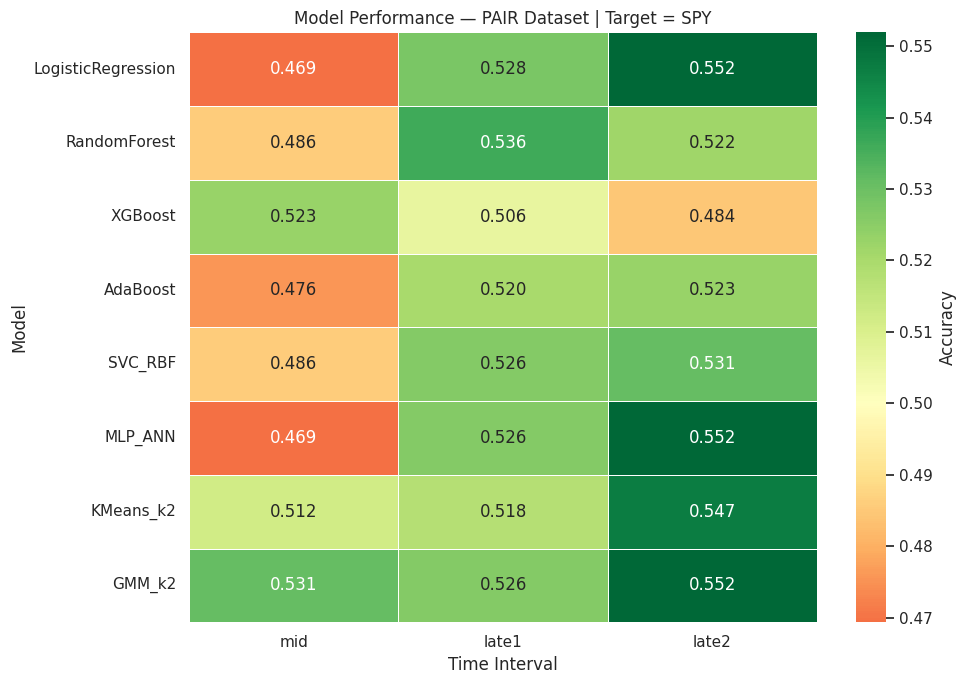

/tmp/ipython-input-3032285488.py:48: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = sub.pivot_table(


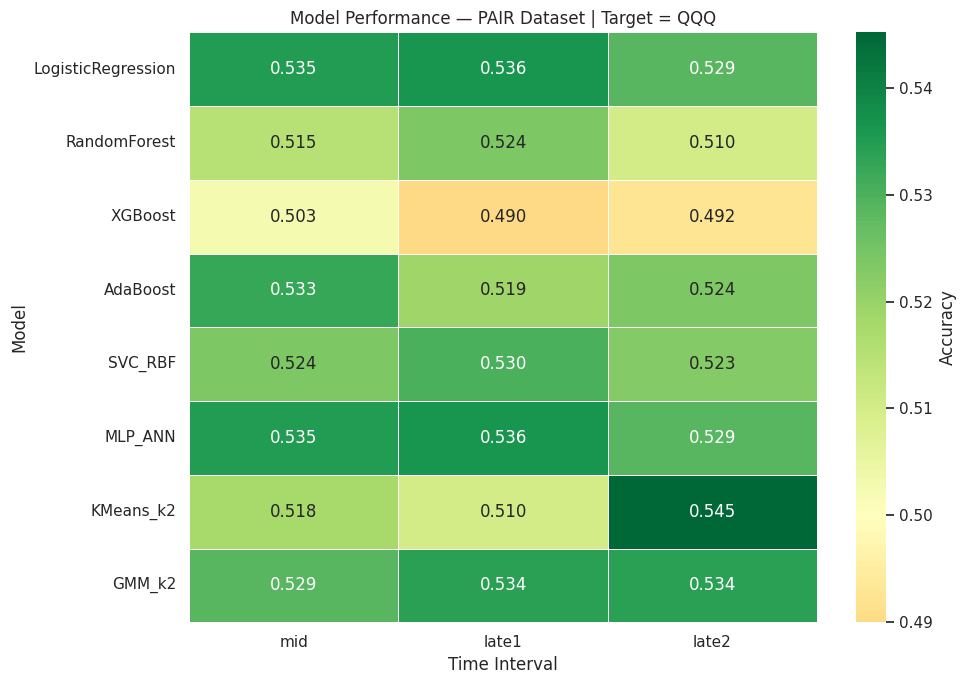

/tmp/ipython-input-3032285488.py:48: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = sub.pivot_table(


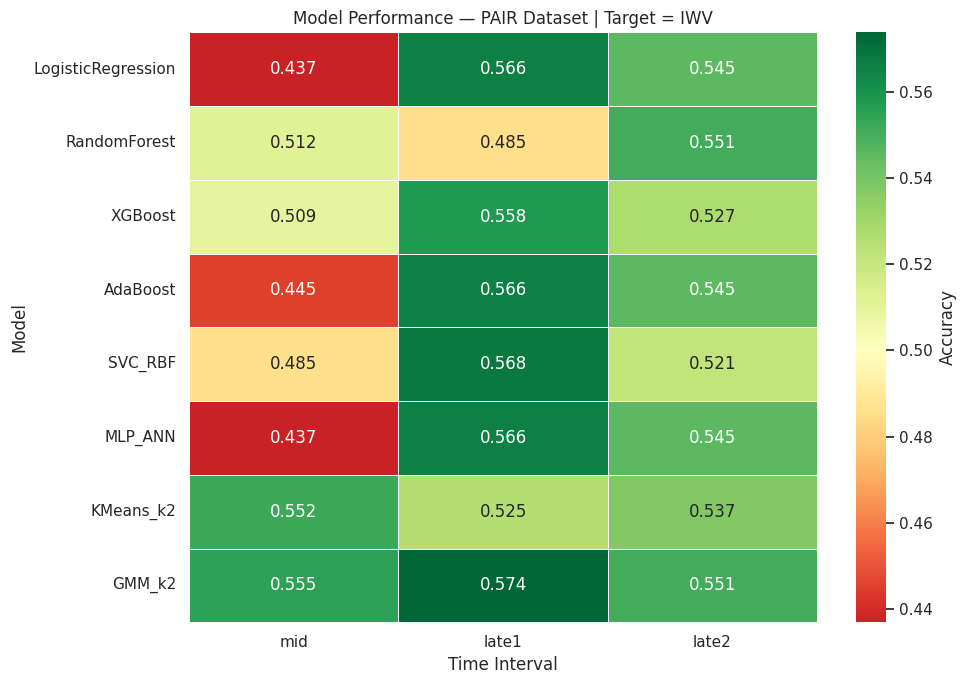

/tmp/ipython-input-3032285488.py:48: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = sub.pivot_table(


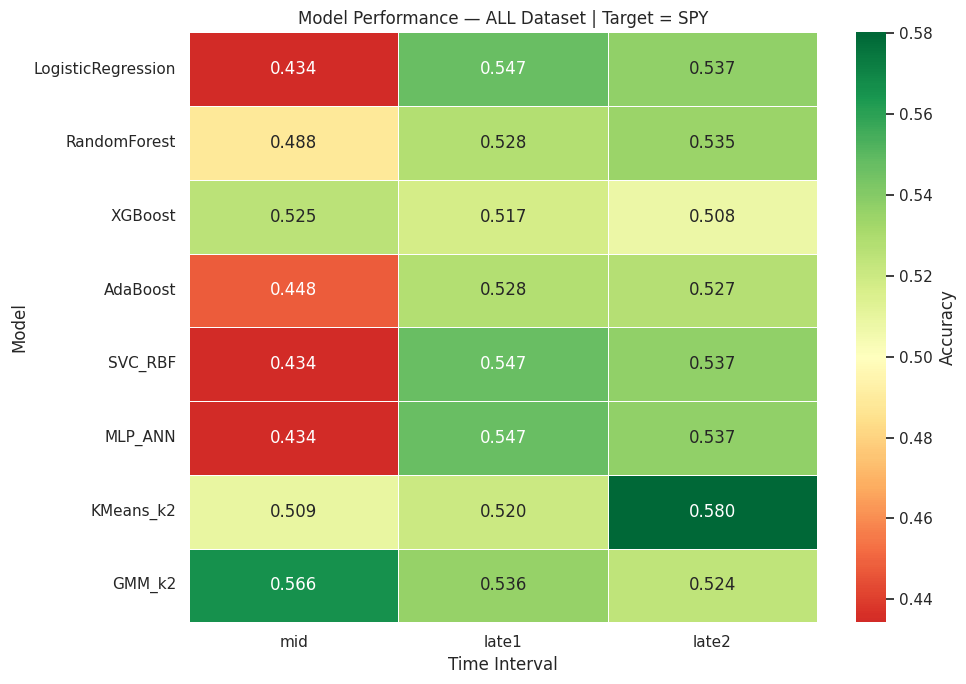

/tmp/ipython-input-3032285488.py:48: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = sub.pivot_table(


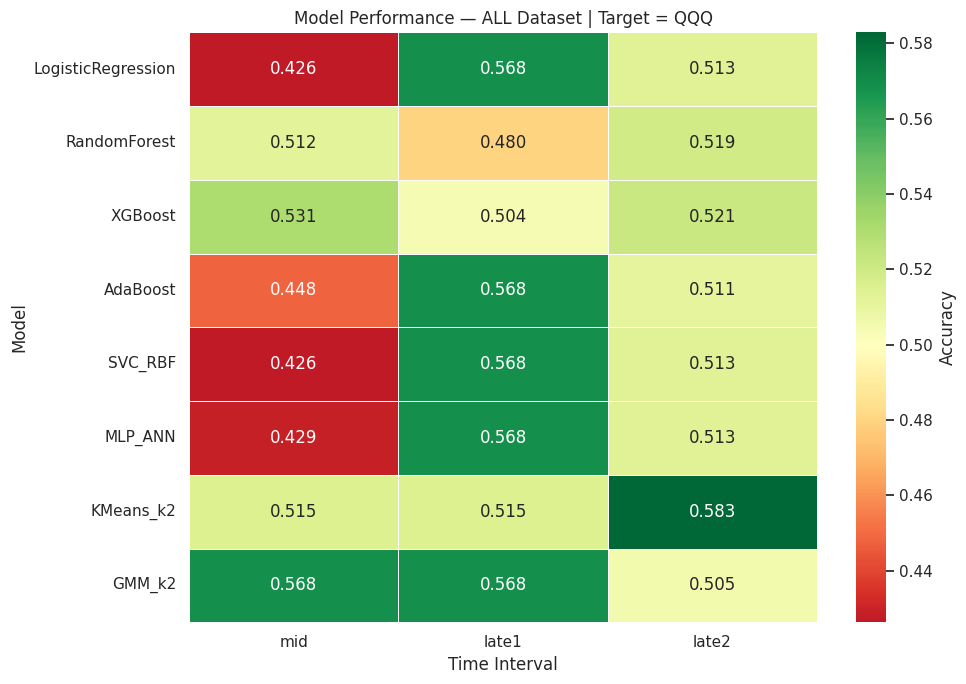

/tmp/ipython-input-3032285488.py:48: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = sub.pivot_table(


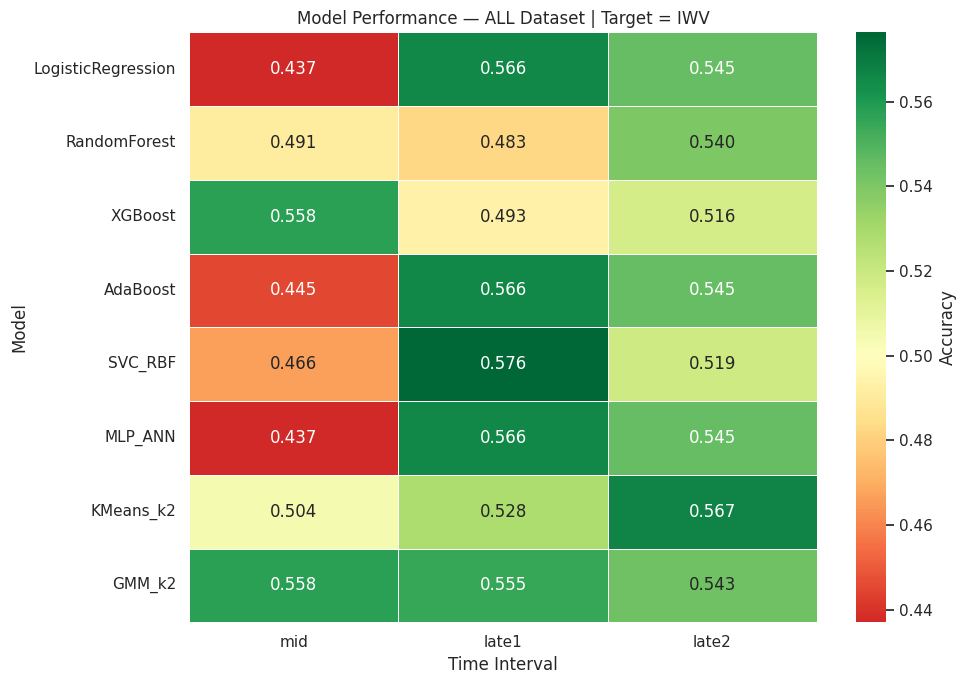

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ========================================================
# LOAD RESULTS (you already confirmed this file exists)
# ========================================================
csv_path = "/content/drive/MyDrive/btc_etf_pair_vs_all_results.csv"
df = pd.read_csv(csv_path)

# ========================================================
# CLEAN CATEGORIES FOR ORDERING
# ========================================================
model_order = [
    "LogisticRegression",
    "RandomForest",
    "XGBoost",
    "AdaBoost",
    "SVC_RBF",
    "MLP_ANN",
    "KMeans_k2",
    "GMM_k2",
]

interval_order = ["mid", "late1", "late2"]

df["model"] = pd.Categorical(df["model"], categories=model_order, ordered=True)
df["interval"] = pd.Categorical(df["interval"], categories=interval_order, ordered=True)

sns.set(style="whitegrid", font_scale=1.0)

# ========================================================
# CREATE MASTER MULTI-PANEL VISUALIZATION
# ========================================================

dataset_types = df["dataset_type"].unique()
targets = df["target_etf"].unique()

for dataset in dataset_types:
    for target in targets:

        sub = df[(df["dataset_type"] == dataset) &
                 (df["target_etf"] == target)]

        if sub.empty:
            continue

        pivot = sub.pivot_table(
            index="model",
            columns="interval",
            values="accuracy"
        )

        plt.figure(figsize=(10, 7))

        sns.heatmap(
            pivot,
            annot=True,
            cmap="RdYlGn",
            fmt=".3f",
            center=0.50,
            linewidths=.5,
            cbar_kws={"label": "Accuracy"}
        )

        plt.title(f"Model Performance — {dataset.upper()} Dataset | Target = {target}")
        plt.xlabel("Time Interval")
        plt.ylabel("Model")
        plt.tight_layout()
        plt.show()


Loaded XGBoost rows: 18


,dataset_type,target_etf,model,interval,n_test,accuracy,moe_95,precision_pos,recall_pos,f1_pos
6,pair,SPY,XGBoost,mid,799,0.523154,0.034633,0.555844,0.504717,0.529048
7,pair,SPY,XGBoost,late1,798,0.506266,0.034689,0.529158,0.581948,0.554299
8,pair,SPY,XGBoost,late2,799,0.484355,0.034653,0.532880,0.532880,0.532880
30,pair,QQQ,XGBoost,mid,796,0.502513,0.034735,0.535211,0.535211,0.535211
31,pair,QQQ,XGBoost,late1,796,0.489950,0.034728,0.520629,0.620609,0.566239


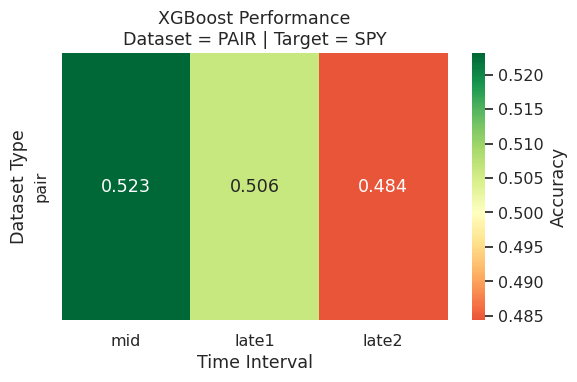

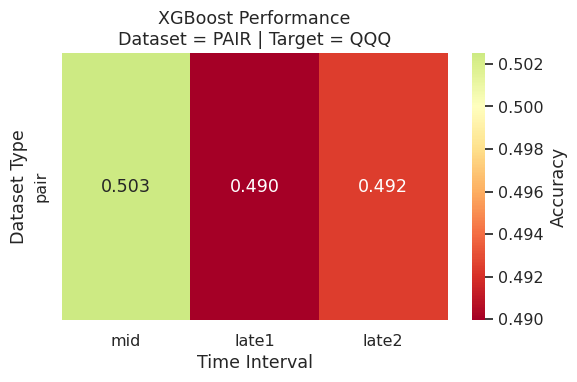

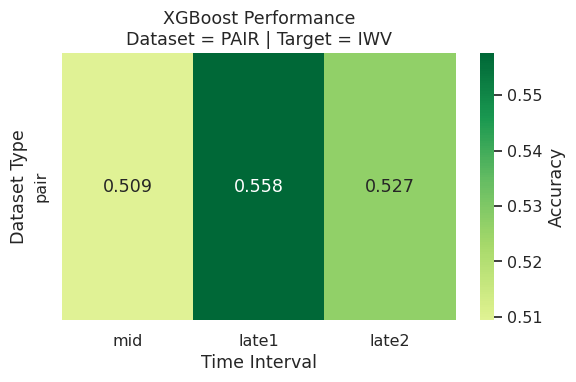

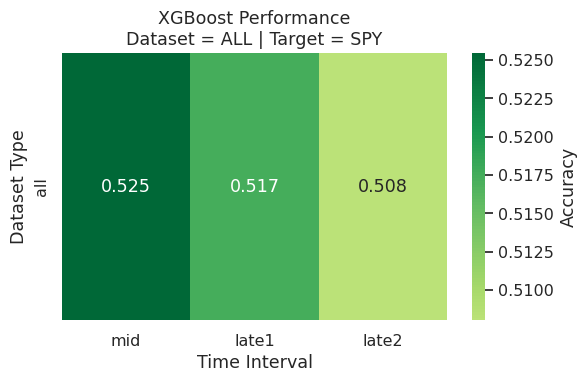

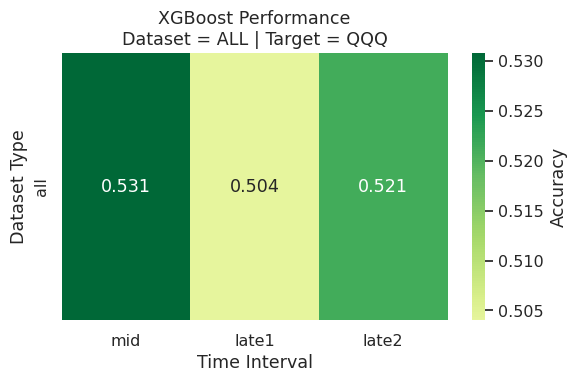

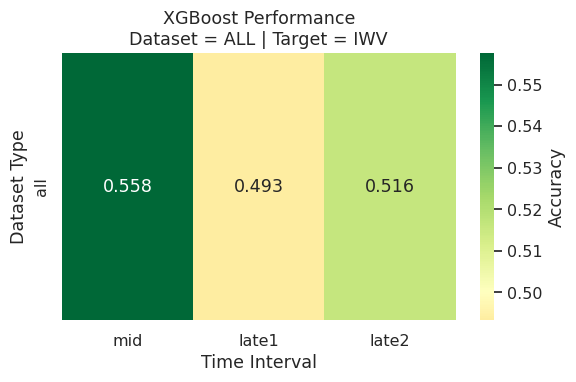

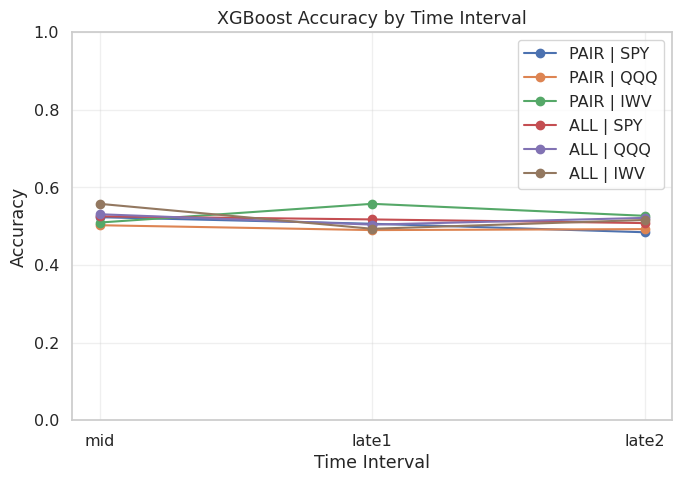

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ============================
# 1. LOAD RESULTS
# ============================
csv_path = "/content/drive/MyDrive/btc_etf_pair_vs_all_results.csv"
results = pd.read_csv(csv_path)

# Filter only XGBoost
xgb = results[results["model"] == "XGBoost"].copy()

print("Loaded XGBoost rows:", len(xgb))
display(xgb.head())

# Ensure correct ordering
interval_order = ["mid", "late1", "late2"]
xgb["interval"] = pd.Categorical(xgb["interval"], categories=interval_order, ordered=True)

# ============================
# 2. HEATMAP: ACCURACY BY TIME INTERVAL
# one heatmap per dataset-type & target
# ============================

sns.set(style="whitegrid", font_scale=1.05)

for dataset_type in xgb["dataset_type"].unique():
    for target in xgb["target_etf"].unique():

        sub = xgb[(xgb["dataset_type"] == dataset_type) &
                  (xgb["target_etf"] == target)]

        if sub.empty:
            continue

        pivot = sub.pivot(index="dataset_type", columns="interval", values="accuracy")

        plt.figure(figsize=(6, 4))
        sns.heatmap(
            pivot,
            annot=True,
            cmap="RdYlGn",
            center=0.5,
            fmt=".3f",
            cbar_kws={"label": "Accuracy"}
        )

        plt.title(f"XGBoost Performance\nDataset = {dataset_type.upper()} | Target = {target}")
        plt.xlabel("Time Interval")
        plt.ylabel("Dataset Type")
        plt.tight_layout()
        plt.show()

# ============================
# 3. LINE CHART: XGB ACCURACY VS TIME INTERVAL
# ============================

plt.figure(figsize=(7,5))

for dataset_type in xgb["dataset_type"].unique():
    for target in xgb["target_etf"].unique():
        sub = xgb[(xgb["dataset_type"] == dataset_type) &
                  (xgb["target_etf"] == target)]

        if sub.empty:
            continue

        sub = sub.sort_values("interval")  # ensure order mid → late1 → late2
        label = f"{dataset_type.upper()} | {target}"
        plt.plot(sub["interval"], sub["accuracy"], marker="o", label=label)

plt.title("XGBoost Accuracy by Time Interval")
plt.xlabel("Time Interval")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


full_results_df loaded with shape: (144, 10)
  dataset_type target_etf               model interval  n_test  accuracy  \
0         pair        SPY  LogisticRegression      mid     799  0.469337   
1         pair        SPY  LogisticRegression    late1     798  0.527569   
2         pair        SPY  LogisticRegression    late2     799  0.551940   
3         pair        SPY        RandomForest      mid     799  0.485607   
4         pair        SPY        RandomForest    late1     798  0.536341   

     moe_95  precision_pos  recall_pos    f1_pos  
0  0.034605       0.000000    0.000000  0.000000  
1  0.034639       0.527569    1.000000  0.690730  
2  0.034482       0.551940    1.000000  0.711290  
3  0.034656       0.520767    0.384434  0.442334  
4  0.034600       0.539291    0.831354  0.654206  
Empty DataFrame
Columns: [dataset_type, target_etf, model, interval, accuracy]
Index: []


/tmp/ipython-input-4181533268.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Dataset type")


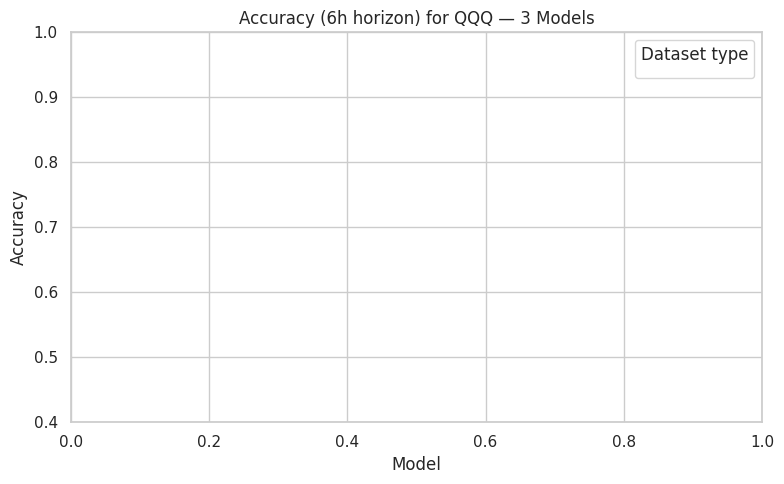

In [ ]:

import pandas as pd

# 🔥 Load your compiled results CSV
full_results_df = pd.read_csv("/content/drive/MyDrive/btc_etf_pair_vs_all_results.csv")

print("full_results_df loaded with shape:", full_results_df.shape)
print(full_results_df.head())
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIG ---
interval_value = "6h"  # <-- change if your interval label is different
models_to_show = ["LogisticRegression", "RandomForest", "XGBoost"]  # pick any 3
target = "QQQ"  # or "SPY", "IWV", etc.

# --- FILTER TO 6H + 3 MODELS + ONE TARGET ---
plot_df = full_results_df[
    (full_results_df["interval"] == interval_value) &
    (full_results_df["model"].isin(models_to_show)) &
    (full_results_df["target_etf"] == target)
].copy()

# Safety check
print(plot_df[["dataset_type", "target_etf", "model", "interval", "accuracy"]])

# --- PLOT: 3 MODELS SIDE BY SIDE (GROUPED BY DATASET_TYPE) ---
sns.set(style="whitegrid", font_scale=1.0)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=plot_df,
    x="model",
    y="accuracy",
    hue="dataset_type",   # e.g. "PAIR" vs "ALL"
)

plt.title(f"Accuracy (6h horizon) for {target} — 3 Models")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0.4, 1.0)  # adjust as you like
plt.legend(title="Dataset type")
plt.tight_layout()
plt.show()


In [ ]:
import os

def list_files(base_path, max_depth=2):
    print(f"\n📂 Listing files under: {base_path}\n")
    for root, dirs, files in os.walk(base_path):
        depth = root.replace(base_path, "").count(os.sep)
        if depth > max_depth:
            continue
        for f in files:
            print(os.path.join(root, f))

# Ensure Drive is mounted (safe even if already mounted)
from google.colab import drive
drive.mount("/content/drive", force_remount=False)

# 1️⃣ Colab working directory
list_files("/content", max_depth=1)

# 2️⃣ Google Drive root
list_files("/content/drive/MyDrive", max_depth=2)

# 3️⃣ Just CSV files (recursive)
print("\n📄 CSV files found in MyDrive:\n")
for root, dirs, files in os.walk("/content/drive/MyDrive"):
    for f in files:
        if f.lower().endswith(".csv"):
            print(os.path.join(root, f))


Mounted at /content/drive

📂 Listing files under: /content

/content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
/content/.config/default_configs.db
/content/.config/.last_update_check.json
/content/.config/.last_survey_prompt.yaml
/content/.config/gce
/content/.config/config_sentinel
/content/.config/active_config
/content/.config/.last_opt_in_prompt.yaml
/content/sample_data/anscombe.json
/content/sample_data/README.md
/content/sample_data/california_housing_train.csv
/content/sample_data/california_housing_test.csv
/content/sample_data/mnist_test.csv
/content/sample_data/mnist_train_small.csv

📂 Listing files under: /content/drive/MyDrive

/content/drive/MyDrive/Civil Rights.gdoc
/content/drive/MyDrive/Copy of Civil Rights.gdoc
/content/drive/MyDrive/Hw.gdoc
/content/drive/MyDrive/Untitled document (145).gdoc
/content/drive/MyDrive/FINA3303_Investments_Spring2024_Diversification (1).gdoc
/content/drive/MyDrive/FINA3303_Investments_Spring2024_Diversificatio